In [2]:
import uproot 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import scipy.stats as sts
from sklearn.neighbors import KernelDensity
import seaborn as sns
from scipy.optimize import curve_fit, minimize
from copy import deepcopy
import ctypes

In [4]:
!pip install SciencePlots

Defaulting to user installation because normal site-packages is not writeable


In [5]:
plt.style.use(['notebook', 'science'])
plt.rcParams['legend.frameon'] = True
plt.rcParams['legend.title_fontsize'] = 20
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['text.usetex'] = False
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.framealpha'] = 1

plt.rcParams['axes.titlesize'] = 22
plt.rcParams['axes.titlelocation'] = 'left'
plt.rcParams['axes.titleweight'] = 'bold'

# plt.rcParams.keys()

OSError: 'notebook' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

In [6]:
import ROOT

Welcome to JupyROOT 6.28/06


In [7]:
from parametrize import fff, ffm

In [8]:
def expo1(x, pars):
    return ROOT.TMath.Exp(x[0]*pars[0]+pars[1])+pars[2]
    
def expo1_np(x, pars):
    return np.exp(x*pars[0]+pars[1])+pars[2]


def expo2(x, pars):
    return ROOT.TMath.Exp(pars[0]*x[0] + pars[1]) + ROOT.TMath.Exp(pars[2]*x[0] + pars[3]) + pars[4]

def expo2_np(x, pars):
    return np.exp(pars[0]*x + pars[1]) + np.exp(pars[2]*x + pars[3]) + pars[4]

def pol2(x, a, b, c):
    return a*(x-b)*(x-b)+c

In [9]:
cc_sat = ROOT.TCanvas('sat_fit','', 1000, 800)
def sat_fit(xpar, ypar, expar, eypar, iistart=0, iistop=None, xl=0.02, xu=0.5, pars=None):
#     iistart, iistop = 0, None
    cc_sat.cd(0)
    grcci = ROOT.TGraphErrors(len(xpar[iistart:iistop]), xpar[iistart:iistop], ypar[iistart:iistop], expar[iistart:iistop], eypar[iistart:iistop])
    grcci.SetNameTitle('grcci', ' ;Charge [pC];SAT [ps]')


    fffi = ROOT.TF1('ffsat', expo2, xl, xu, 5)
    wFiti = ROOT.Math.WrappedMultiTF1(fffi, 1);
    fopt =  ROOT.Fit.DataOptions()
    fopt.fCoordErrors = False
    rangeB = ROOT.Fit.DataRange()
    if iistop == None:
        rangeB.SetRange(xpar[iistart], xpar[-1])
    else:
        rangeB.SetRange(xpar[iistart], xpar[iistop])
    dataB = ROOT.Fit.BinData(fopt, rangeB);
    ROOT.Fit.FillData(dataB, grcci);
    chi2f = ROOT.Fit.Chi2Function(dataB, wFiti)

    fitter = ROOT.Fit.Fitter()

    par0 = np.array([-1.19593947e+01,  1.52272605e+01, -5.23861833e-01,  5.09975903e+00, 100])
    if pars != None:
        par0 = np.array(pars)
        
    fitter.Config().SetParamsSettings(5, par0)
    fitter.Config().MinimizerOptions().SetPrintLevel(1)
    fitter.Config().MinimizerOptions().SetMaxFunctionCalls(100000) # for Minuit/Minuit2
    fitter.Config().MinimizerOptions().SetMaxIterations(10000) # for GSL
    fitter.Config().SetMinimizer("Minuit2", "Migrad")

    fitter.FitFCN(chi2f)
    result = fitter.Result()

    parsi = np.zeros(5)
    for i in range(5):
        parsi[i] = fffi.GetParameter(i)
#     print(parsi)


    grcci.GetListOfFunctions().Add(fffi)
    grcci.DrawClone('ap')

    cc_sat.Draw()
    return parsi

In [10]:
def weird_gaussian( x, p ):
    #c, mu1, mu2, sigma = params
    res =   p[0] * (np.exp( - (x[0] - p[1])**2.0 / (2.0 * p[3]**2.0) ) \
          + np.exp( - (x[0] - p[2])**2.0 / (2.0 * p[3]**2.0) ))
    return res

def weirdo_gaussian( x, *p ):
    c, mu1, mu2, sigma = p
    res =   c * (np.exp( - (x - mu1)**2.0 / (2.0 * sigma**2.0) ) \
          + np.exp( - (x - mu2)**2.0 / (2.0 * sigma**2.0) ))
    return res

def parabola( x, p ):
    res =   p[0] * (x[0]-p[1])**2 +p[2]
    return res

def parabolic( x, *p ):
    a, mu, b = p
    res =   a*(x-mu)**2+b
    return res

def sym_to_beam(xy , theta):
    x,y = xy
    return (x*np.cos(theta)+y*np.sin(theta), -x*np.sin(theta)+y*np.cos(theta))

In [27]:
#scan_files = {'/eos/home-i/iangelis/RD51/code/ebeam/analysis/July2023/Run320/run320_merged.root':'Pico'}
#scan_files = {'/eos/home-i/iangelis/RD51/code/ebeam/analysis/July2023/Run320/run320_merged_tracks.root':'Pico'}
#scan_files = {'/eos/home-a/akallits/SWAN_projects/pico/run320_merged.root':'Pico'}
scan_files = {'/eos/home-a/akallits/SWAN_projects/pico/run323_merged.root':'Pico'}

In [28]:
vall = uproot.concatenate(scan_files,
['mcp1_v', 'mcp1_q', 'mcp1_t', \
'mcp2_v', 'mcp2_q', 'mcp2_t', \
'mcp3_v', 'mcp3_q', 'mcp3_t', \
'mcp4_v', 'mcp4_q', 'mcp4_t', \
'mm1_v', 'mm1_qe', 'mm1_qall', 'mm1_t',
'mm2_v', 'mm2_qe', 'mm2_qall', 'mm2_t',
'mm3_v', 'mm3_qe', 'mm3_qall', 'mm3_t',
'mm4_v', 'mm4_qe', 'mm4_qall', 'mm4_t',
'mm5_v', 'mm5_qe', 'mm5_qall', 'mm5_t',
'mm6_v', 'mm6_qe', 'mm6_qall', 'mm6_t',
'mm7_v', 'mm7_qe', 'mm7_qall', 'mm7_t',
's1_gpeak', 's1_qe', 's1_qall', 's1_tnaive',
's2_gpeak', 's2_qe', 's2_qall', 's2_tnaive',
's3_gpeak', 's3_qe', 's3_qall', 's3_tnaive',
's4_gpeak', 's4_qe', 's4_qall', 's4_tnaive',
 #'ntracks'
# 'ntracks', 'xy', 'track_flag'
], library='np')


In [29]:
mcp1_v   = vall['mcp1_v']
mcp1_q   = vall['mcp1_q']
mcp1_t   = vall['mcp1_t']

mcp2_v   = vall['mcp2_v']
mcp2_q   = vall['mcp2_q']
mcp2_t   = vall['mcp2_t']

mcp3_v   = vall['mcp3_v']
mcp3_q   = vall['mcp3_q']
mcp3_t   = vall['mcp3_t']

mcp4_v   = vall['mcp4_v']
mcp4_q   = vall['mcp4_q']
mcp4_t   = vall['mcp4_t']

mm1_v    = vall['mm1_v']
mm1_t    = vall['mm1_t']
mm1_qe   = vall['mm1_qe']
mm1_qall = vall['mm1_qall']

mm2_v    = vall['mm2_v']
mm2_t    = vall['mm2_t']
mm2_qe   = vall['mm2_qe']
mm2_qall = vall['mm2_qall']

mm3_v    = vall['mm3_v']
mm3_t    = vall['mm3_t']
mm3_qe   = vall['mm3_qe']
mm3_qall = vall['mm3_qall']

mm4_v    = vall['mm4_v']
mm4_t    = vall['mm4_t']
mm4_qe   = vall['mm4_qe']
mm4_qall = vall['mm4_qall']

mm5_v    = vall['mm5_v']
mm5_t    = vall['mm5_t']
mm5_qe   = vall['mm5_qe']
mm5_qall = vall['mm5_qall']

mm6_v    = vall['mm6_v']
mm6_t    = vall['mm6_t']
mm6_qe   = vall['mm6_qe']
mm6_qall = vall['mm6_qall']

mm7_v    = vall['mm7_v']
mm7_t    = vall['mm7_t']
mm7_qe   = vall['mm7_qe']
mm7_qall = vall['mm7_qall']

In [30]:
s1_v = vall['s1_gpeak']
s2_v = vall['s2_gpeak']
s3_v = vall['s3_gpeak']
s4_v = vall['s4_gpeak']


ss_v = [ s1_v, s2_v, s3_v, s4_v]

In [31]:
# track_flag  = vall['track_flag']
# valid_tracks = track_flag == 1
ntracks = vall['ntracks']
# xy = vall['xy']

KeyError: 'ntracks'

In [32]:
pad_order = [0,1,2,3,4,5,6]

In [33]:
dt1 = mm1_t - mcp1_t
dt2 = mm2_t - mcp1_t
dt3 = mm3_t - mcp2_t
dt4 = mm4_t - mcp2_t
dt5 = mm5_t - mcp3_t
dt6 = mm6_t - mcp3_t
dt7 = mm7_t - mcp4_t

In [34]:
mcp_vs = [ mcp1_v, mcp2_v, mcp3_v, mcp4_v ]
mcp_qs = [ mcp1_q, mcp2_q, mcp3_q, mcp4_q ]

mm_vs = [ mm1_v,mm2_v,mm3_v,mm4_v,mm5_v,mm6_v,mm7_v ] 
mm_qes = [ mm1_qe,mm2_qe,mm3_qe,mm4_qe,mm5_qe,mm6_qe,mm7_qe ]
mm_qalls = [ mm1_qall,mm2_qall,mm3_qall,mm4_qall,mm5_qall,mm6_qall,mm7_qall ]

mm_dts = [ dt1, dt2, dt3, dt4, dt5, dt6, dt7 ]

In [35]:
NPADS = 7

In [36]:
colors_mcp = ['black', 'maroon', 'blue', 'magenta']
colors = ['red', 'blue', 'magenta', 'green', 'maroon', 'olive', 'yellow']
pnames = ['Pad 1', 'Pad 2', 'Pad 3', 'Pad 4', 'Pad 5', 'Pad 6', 'Pad 7']

In [37]:
N = len(mcp1_v)
print(N)

61087


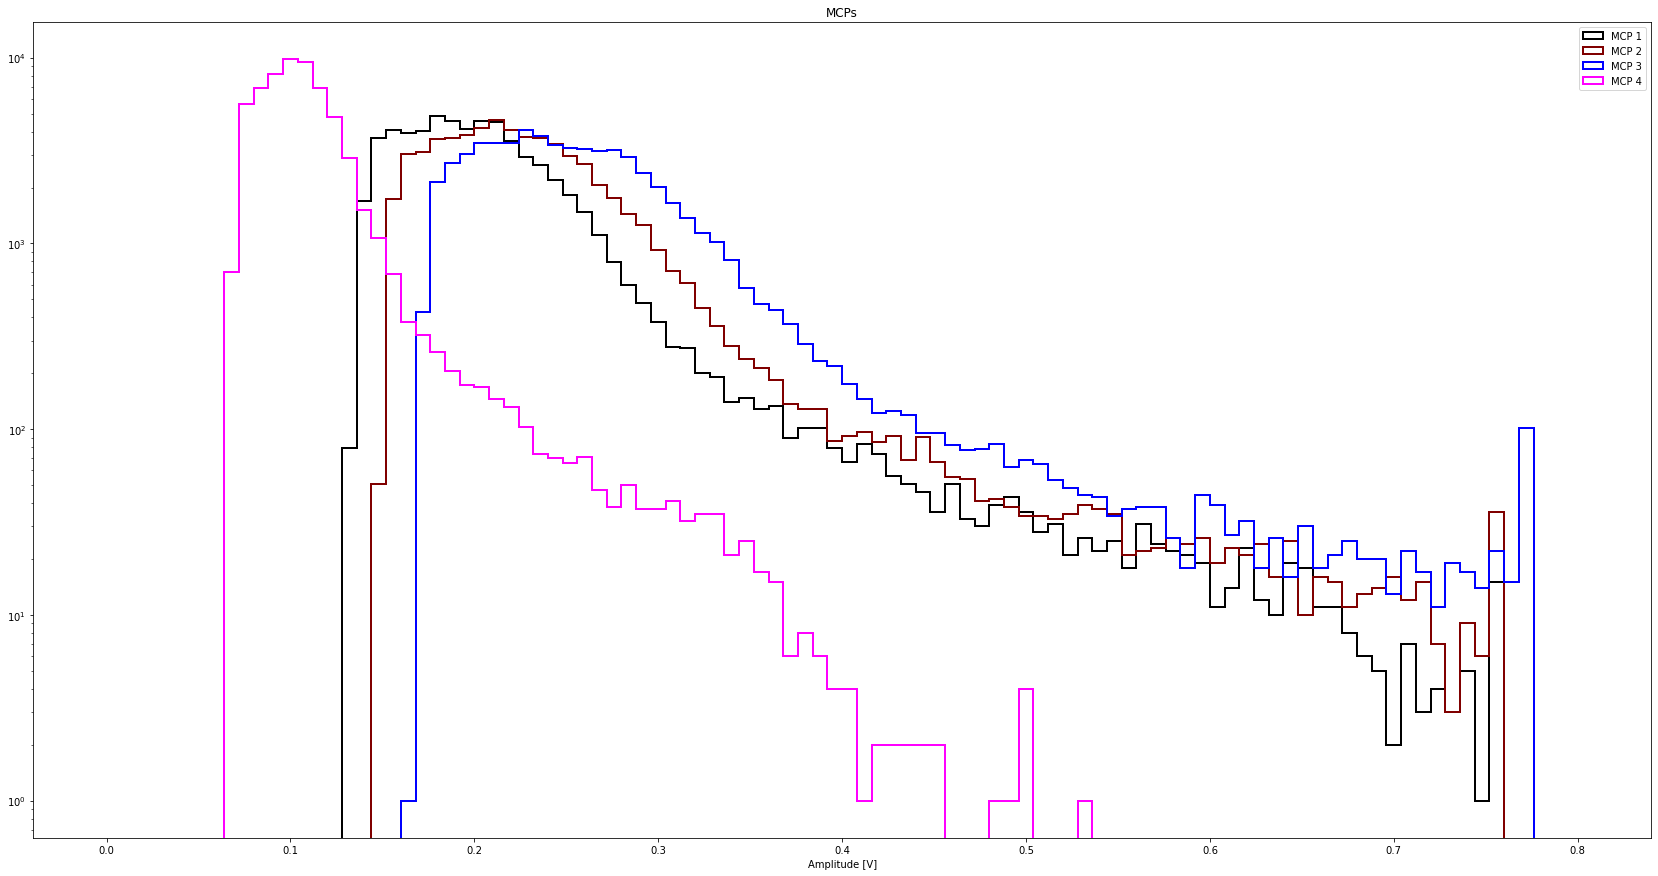

In [38]:
fig, axs = plt.subplots(figsize=(29, 15))
for i in range(len(mcp_vs)):
    axs.hist(mcp_vs[i], bins=100, range=(0.0, 0.8), histtype='step', color=colors_mcp[i], lw=2, label=f'MCP {i+1}')
axs.set_yscale('log')
axs.set_xlabel('Amplitude [V]')
axs.set_title('MCPs')
axs.legend()
plt.show()

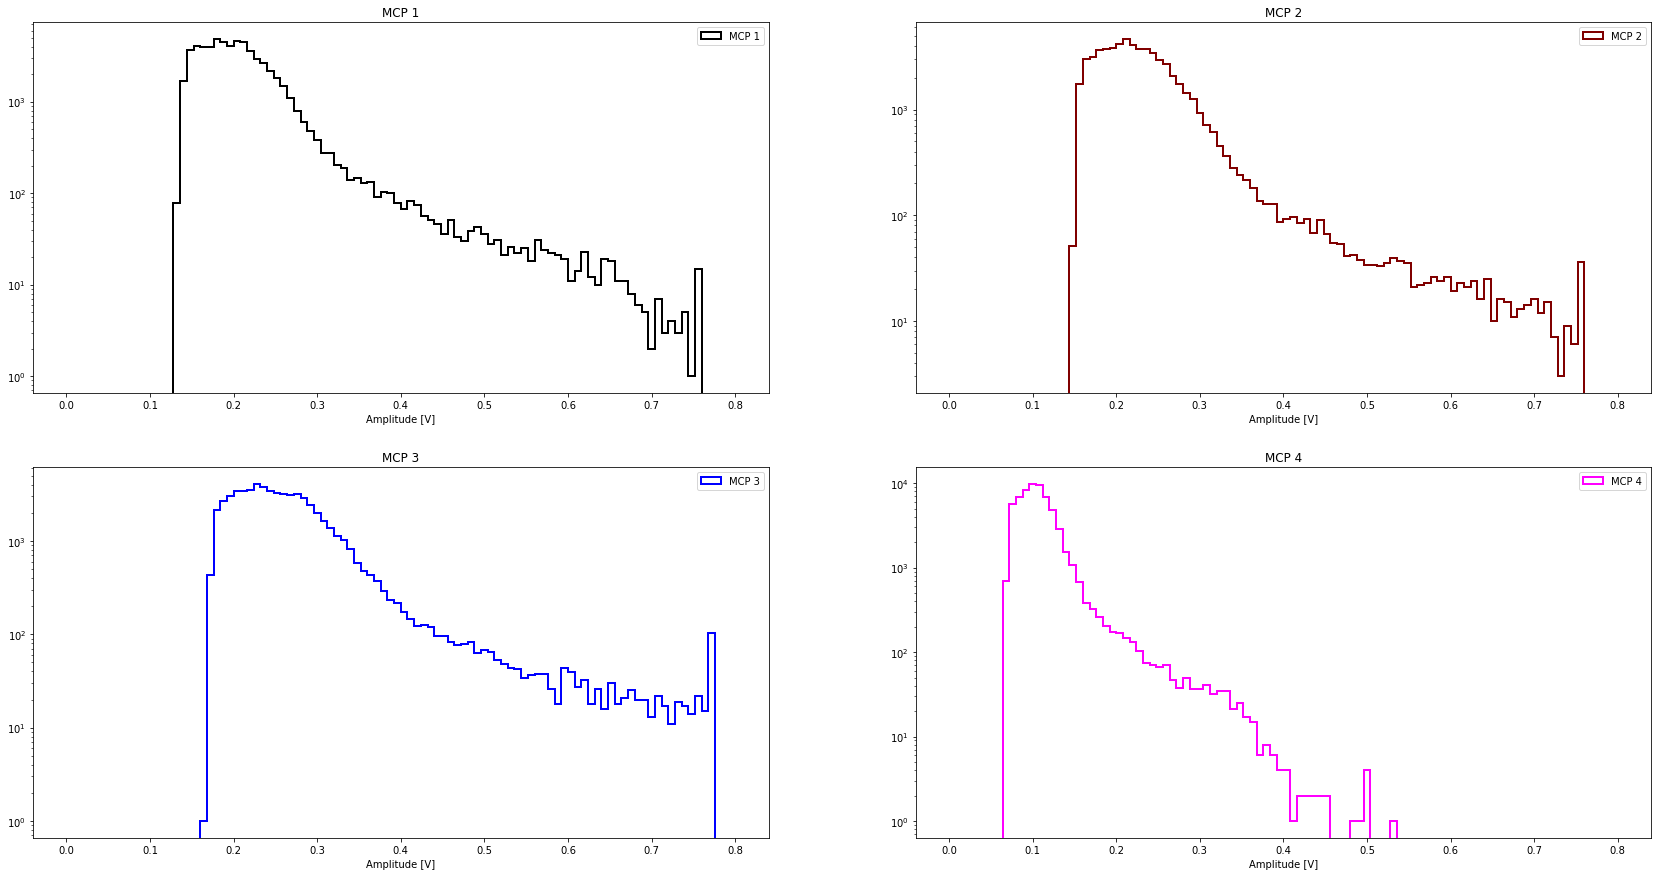

In [39]:
fig, axs = plt.subplots(2, 2, figsize=(29, 15))
axs = axs.ravel()
for i in range(len(mcp_vs)):
    axs[i].hist(mcp_vs[i], bins=100, range=(0.0, 0.8), histtype='step', color=colors_mcp[i], lw=2, label=f'MCP {i+1}')
    axs[i].set_yscale('log')
    axs[i].set_xlabel('Amplitude [V]')
    axs[i].set_title(f'MCP {i+1}')
    axs[i].legend()
plt.show()

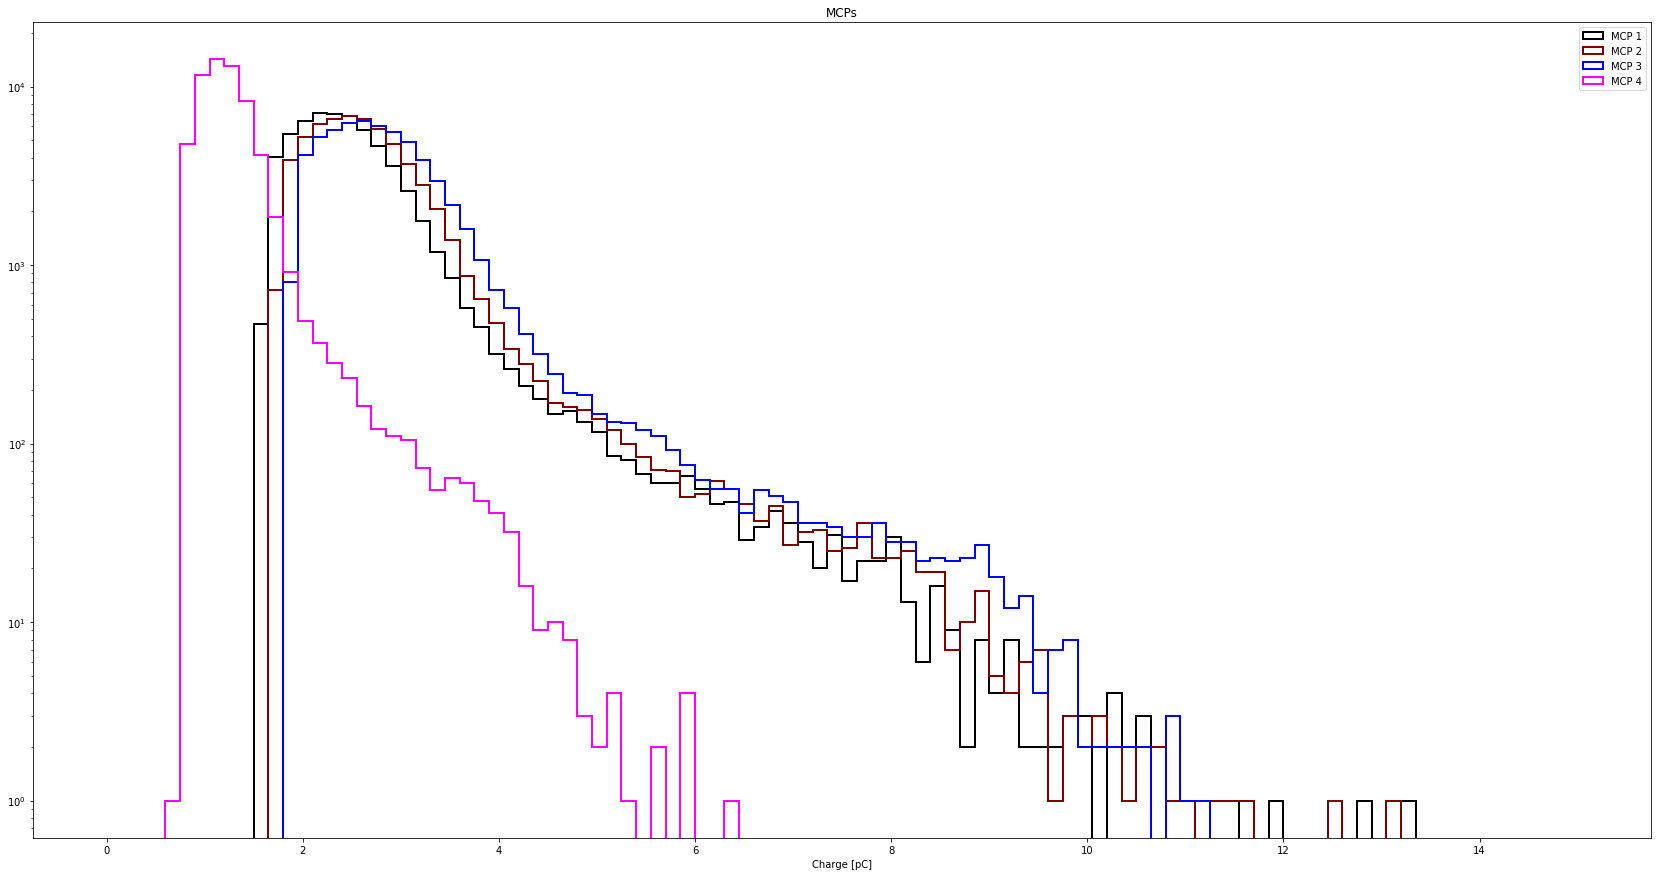

In [40]:
fig, axs = plt.subplots(figsize=(29, 15))
for i in range(len(mcp_vs)):
    axs.hist(mcp_qs[i], bins=100, range=(0.0, 15), histtype='step', color=colors_mcp[i], lw=2, label=f'MCP {i+1}')
axs.set_yscale('log')
axs.set_xlabel('Charge [pC]')
axs.set_title('MCPs')
axs.legend()
plt.show()

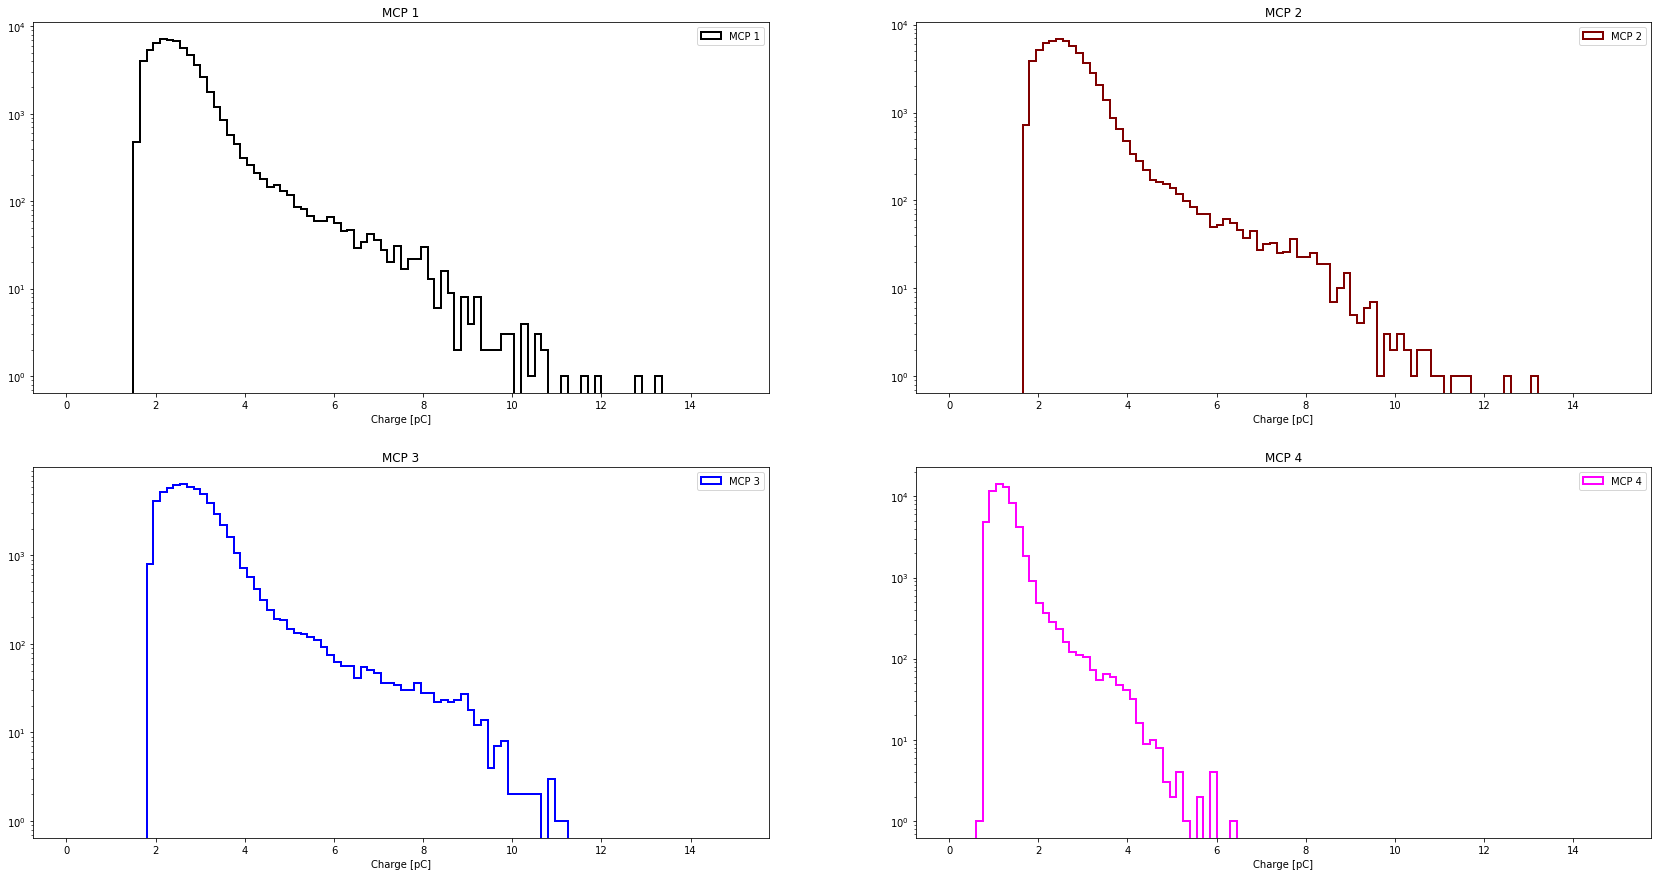

In [41]:
fig, axs = plt.subplots(2, 2, figsize=(29, 15))
axs = axs.ravel()
for i in range(len(mcp_vs)):
    axs[i].hist(mcp_qs[i], bins=100, range=(0.0, 15), histtype='step', color=colors_mcp[i], lw=2, label=f'MCP {i+1}')
    axs[i].set_yscale('log')
    axs[i].set_xlabel('Charge [pC]')
    axs[i].set_title(f'MCP {i+1}')
    axs[i].legend()
plt.show()

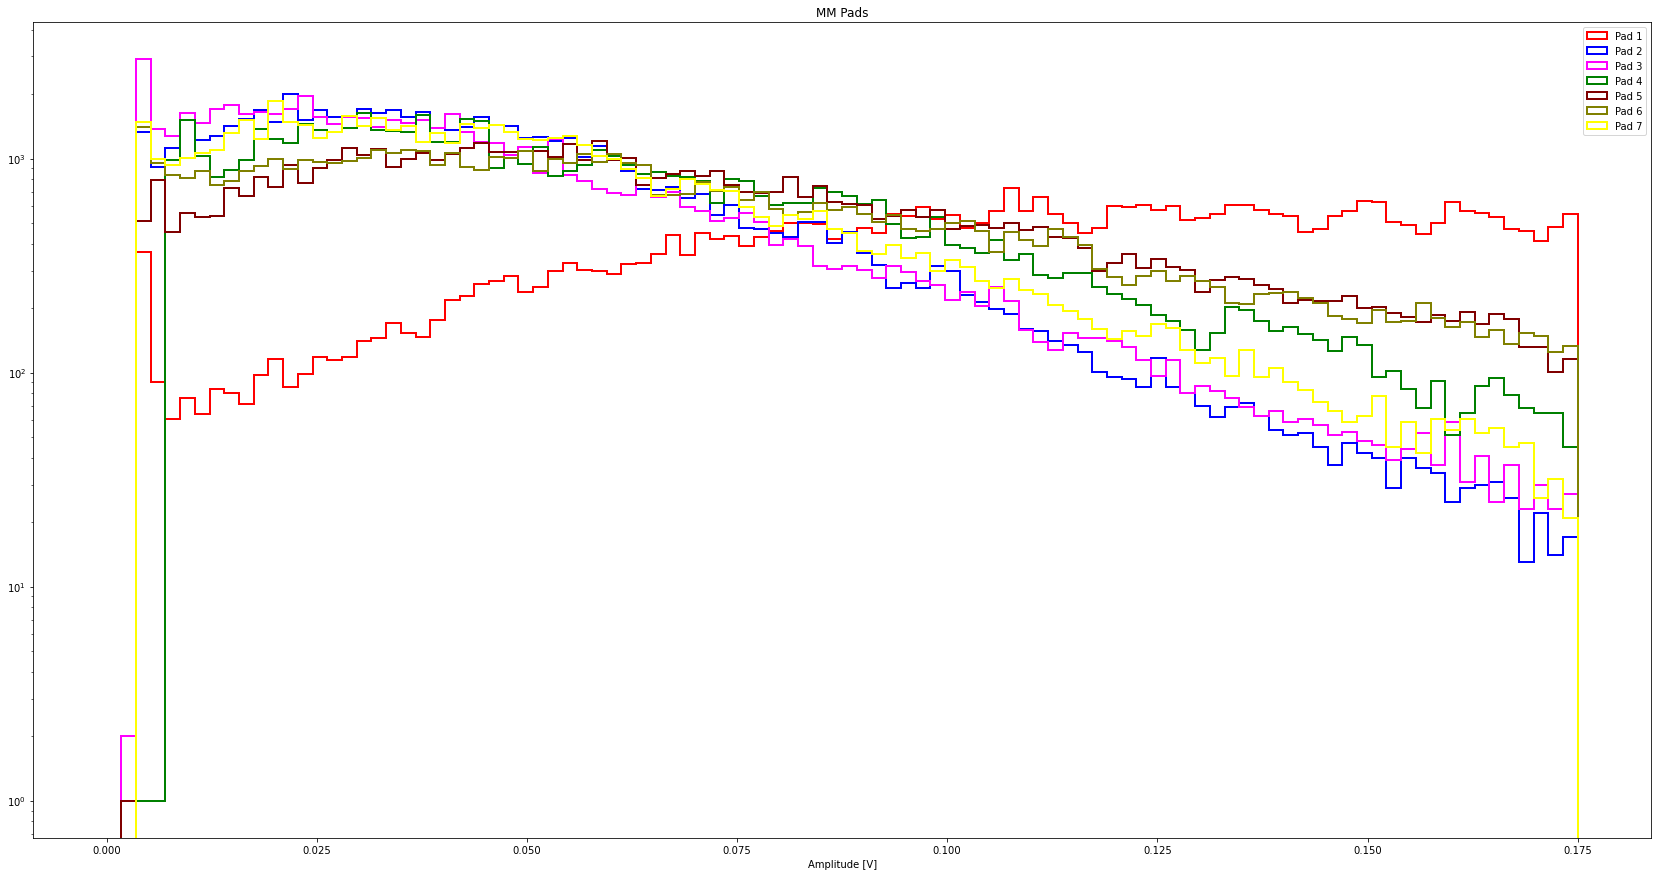

In [42]:
fig, axs = plt.subplots(figsize=(29, 15))
for i in range(len(mm_vs)):
    axs.hist(mm_vs[i], bins=100, range=(0.0, 0.175), histtype='step', color=colors[i], lw=2, label=f'Pad {i+1}')
axs.set_yscale('log')
axs.set_xlabel('Amplitude [V]')
axs.set_title('MM Pads')
axs.legend()
plt.show()

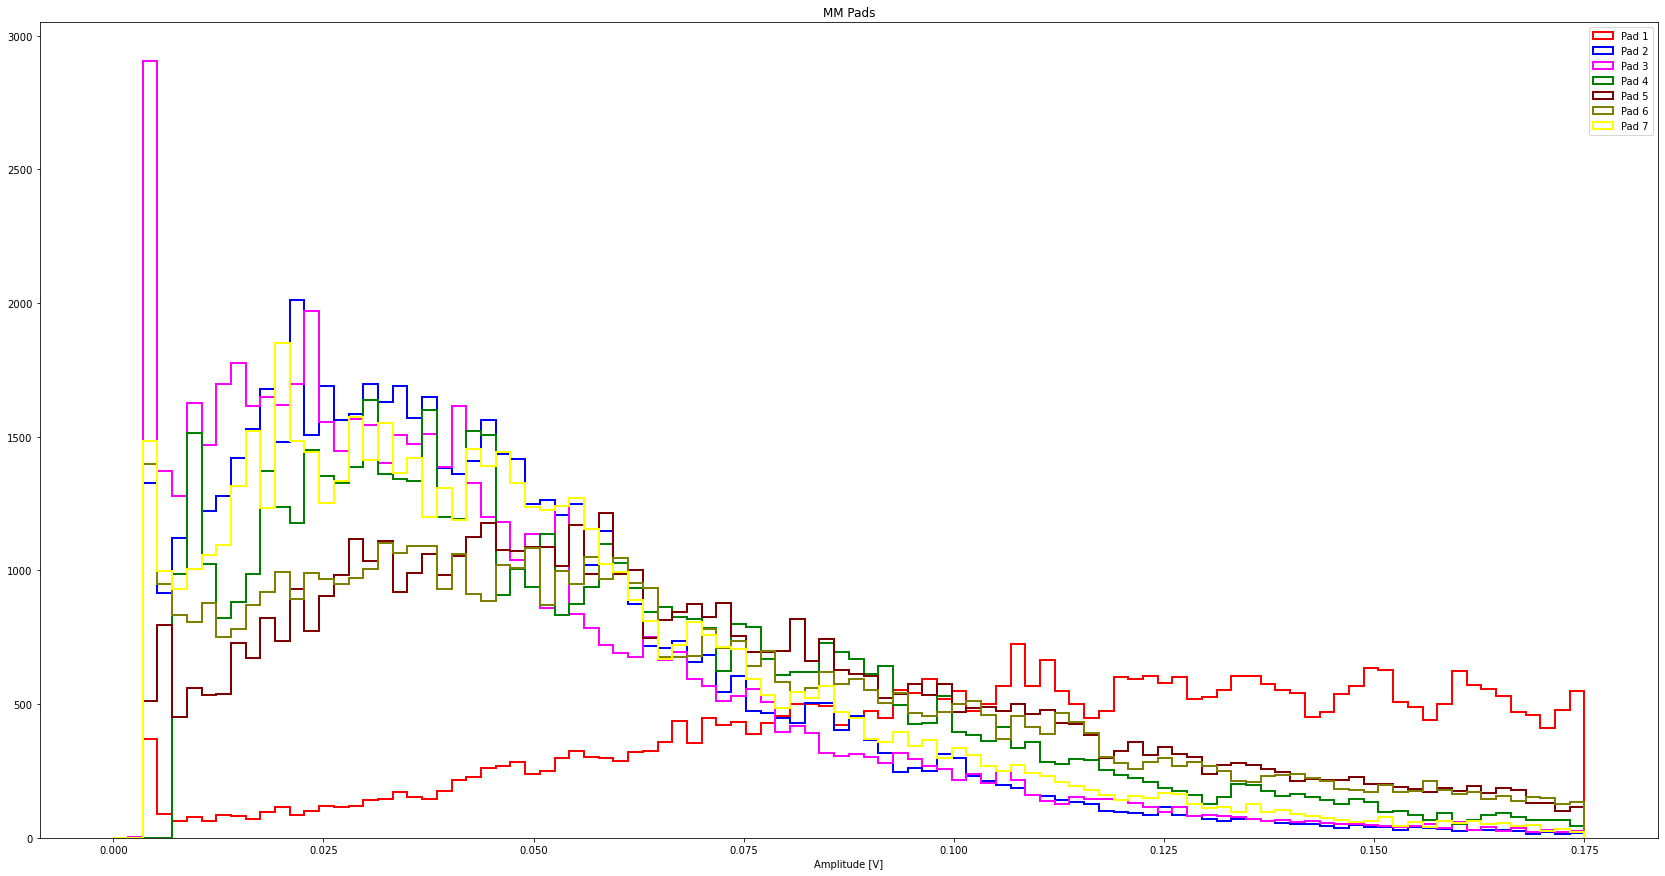

In [43]:
fig, axs = plt.subplots(figsize=(29, 15))
for i in range(len(mm_vs)):
    axs.hist(mm_vs[i], bins=100, range=(0.0, 0.175), histtype='step', color=colors[i], lw=2, label=f'Pad {i+1}')
#axs.set_yscale('log')
axs.set_xlabel('Amplitude [V]')
axs.set_title('MM Pads')
axs.legend()
plt.show()

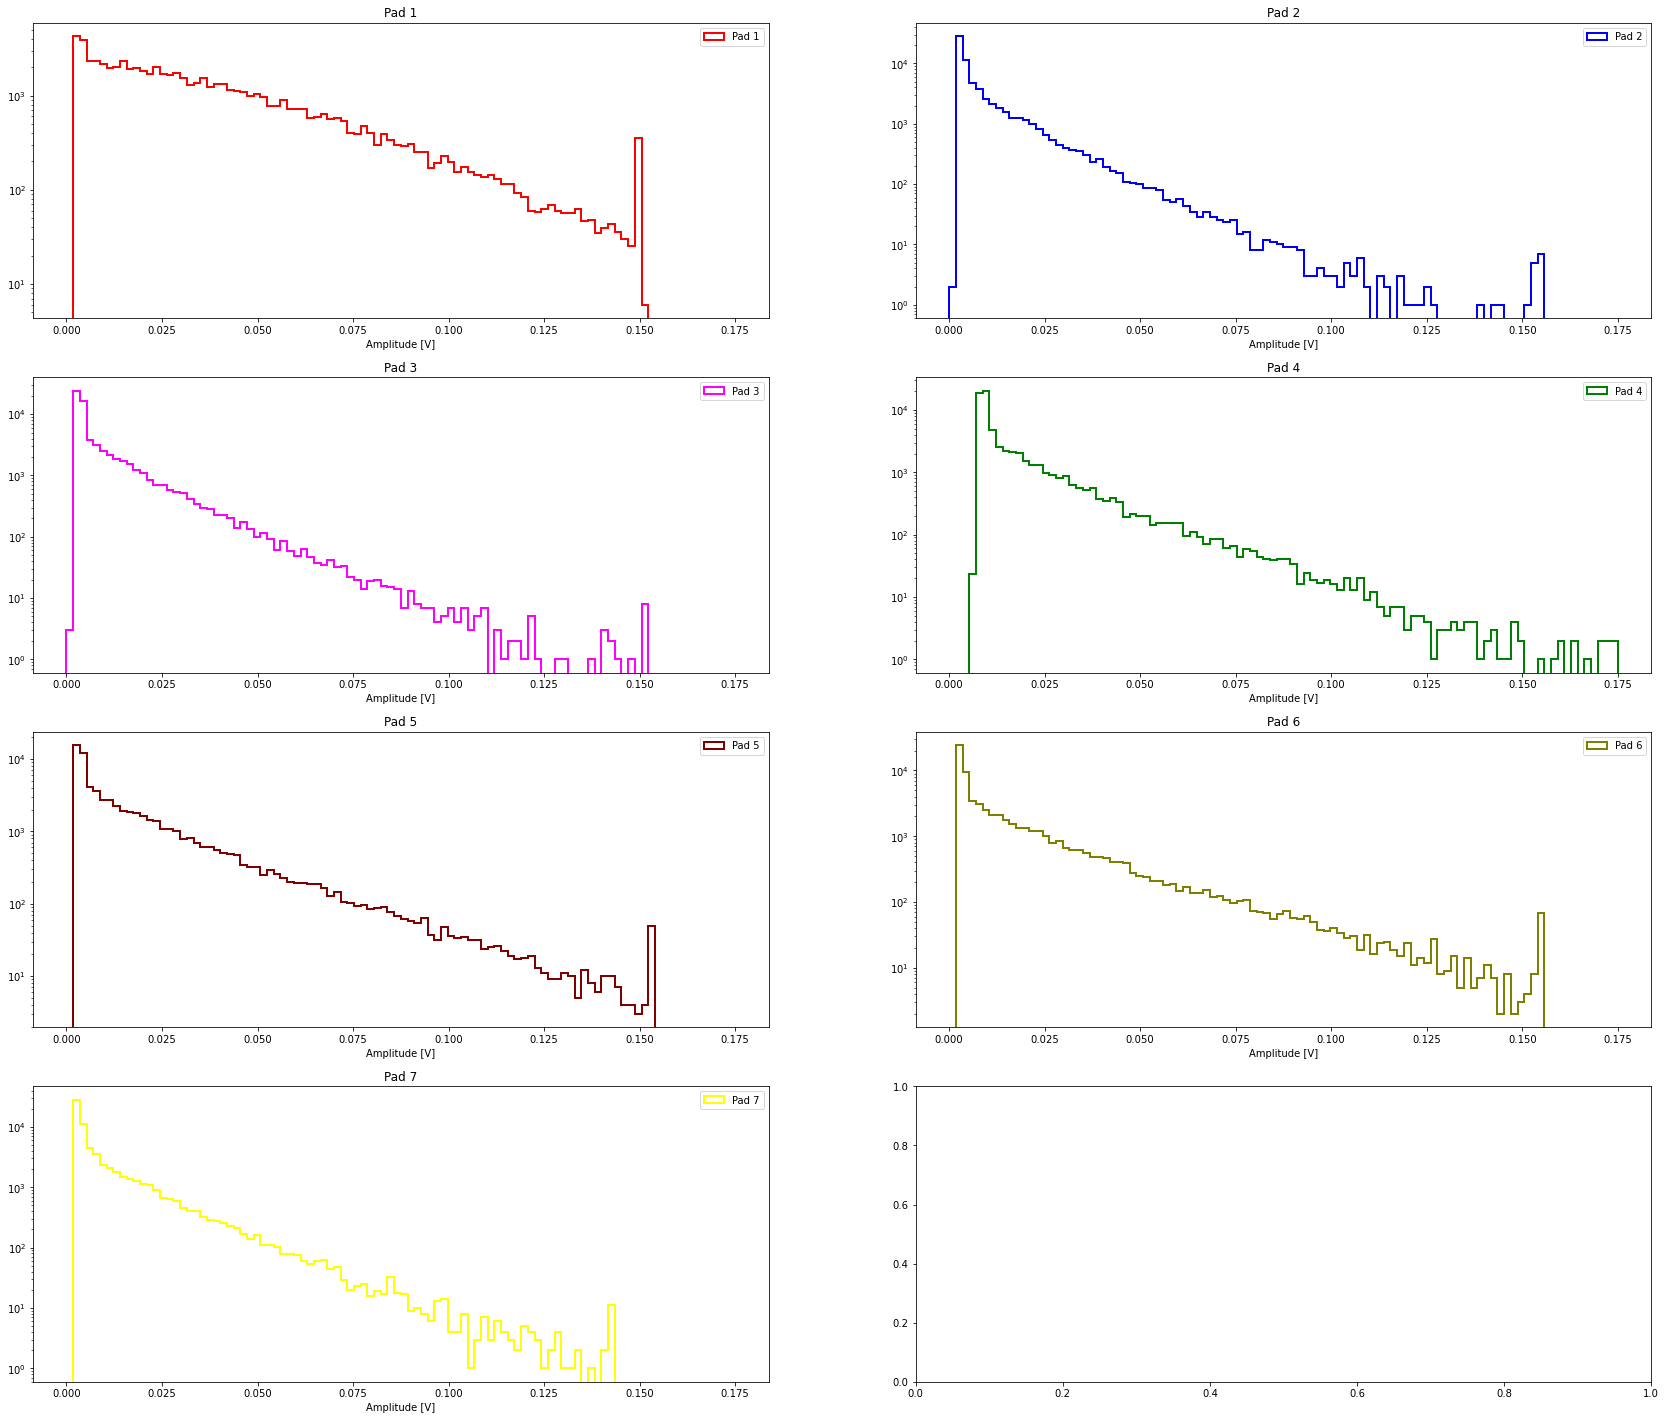

In [106]:
fig, axs = plt.subplots(4,2,figsize=(29, 25))
axs=axs.ravel()
for i in range(len(mm_vs)):
    axs[i].hist(mm_vs[i], bins=100, range=(0.0, 0.175), histtype='step', color=colors[i], lw=2, label=f'Pad {i+1}')
    axs[i].set_yscale('log')
    axs[i].set_xlabel('Amplitude [V]')
    axs[i].set_title(f'Pad {i+1}')
    axs[i].legend()
plt.show()

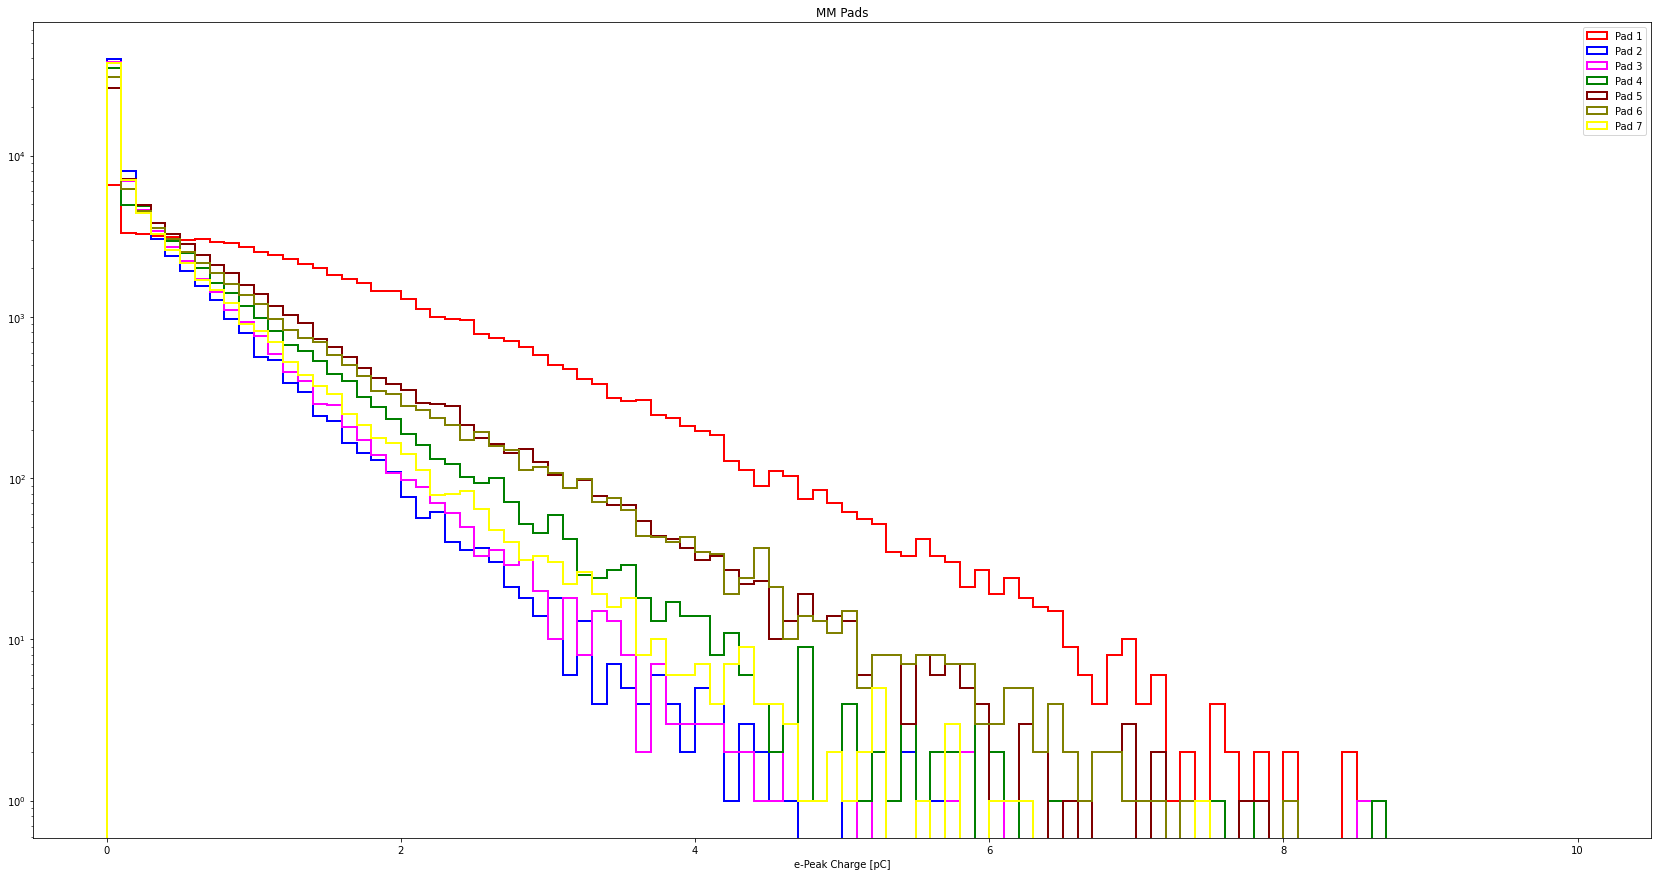

In [107]:
fig, axs = plt.subplots(figsize=(29, 15))
for i in range(len(mm_vs)):
    axs.hist(mm_qes[i], bins=100, range=(0.0, 10), histtype='step', color=colors[i], lw=2, label=f'Pad {i+1}')
axs.set_yscale('log')
axs.set_xlabel('e-Peak Charge [pC]')
axs.set_title('MM Pads')
axs.legend()
plt.show()

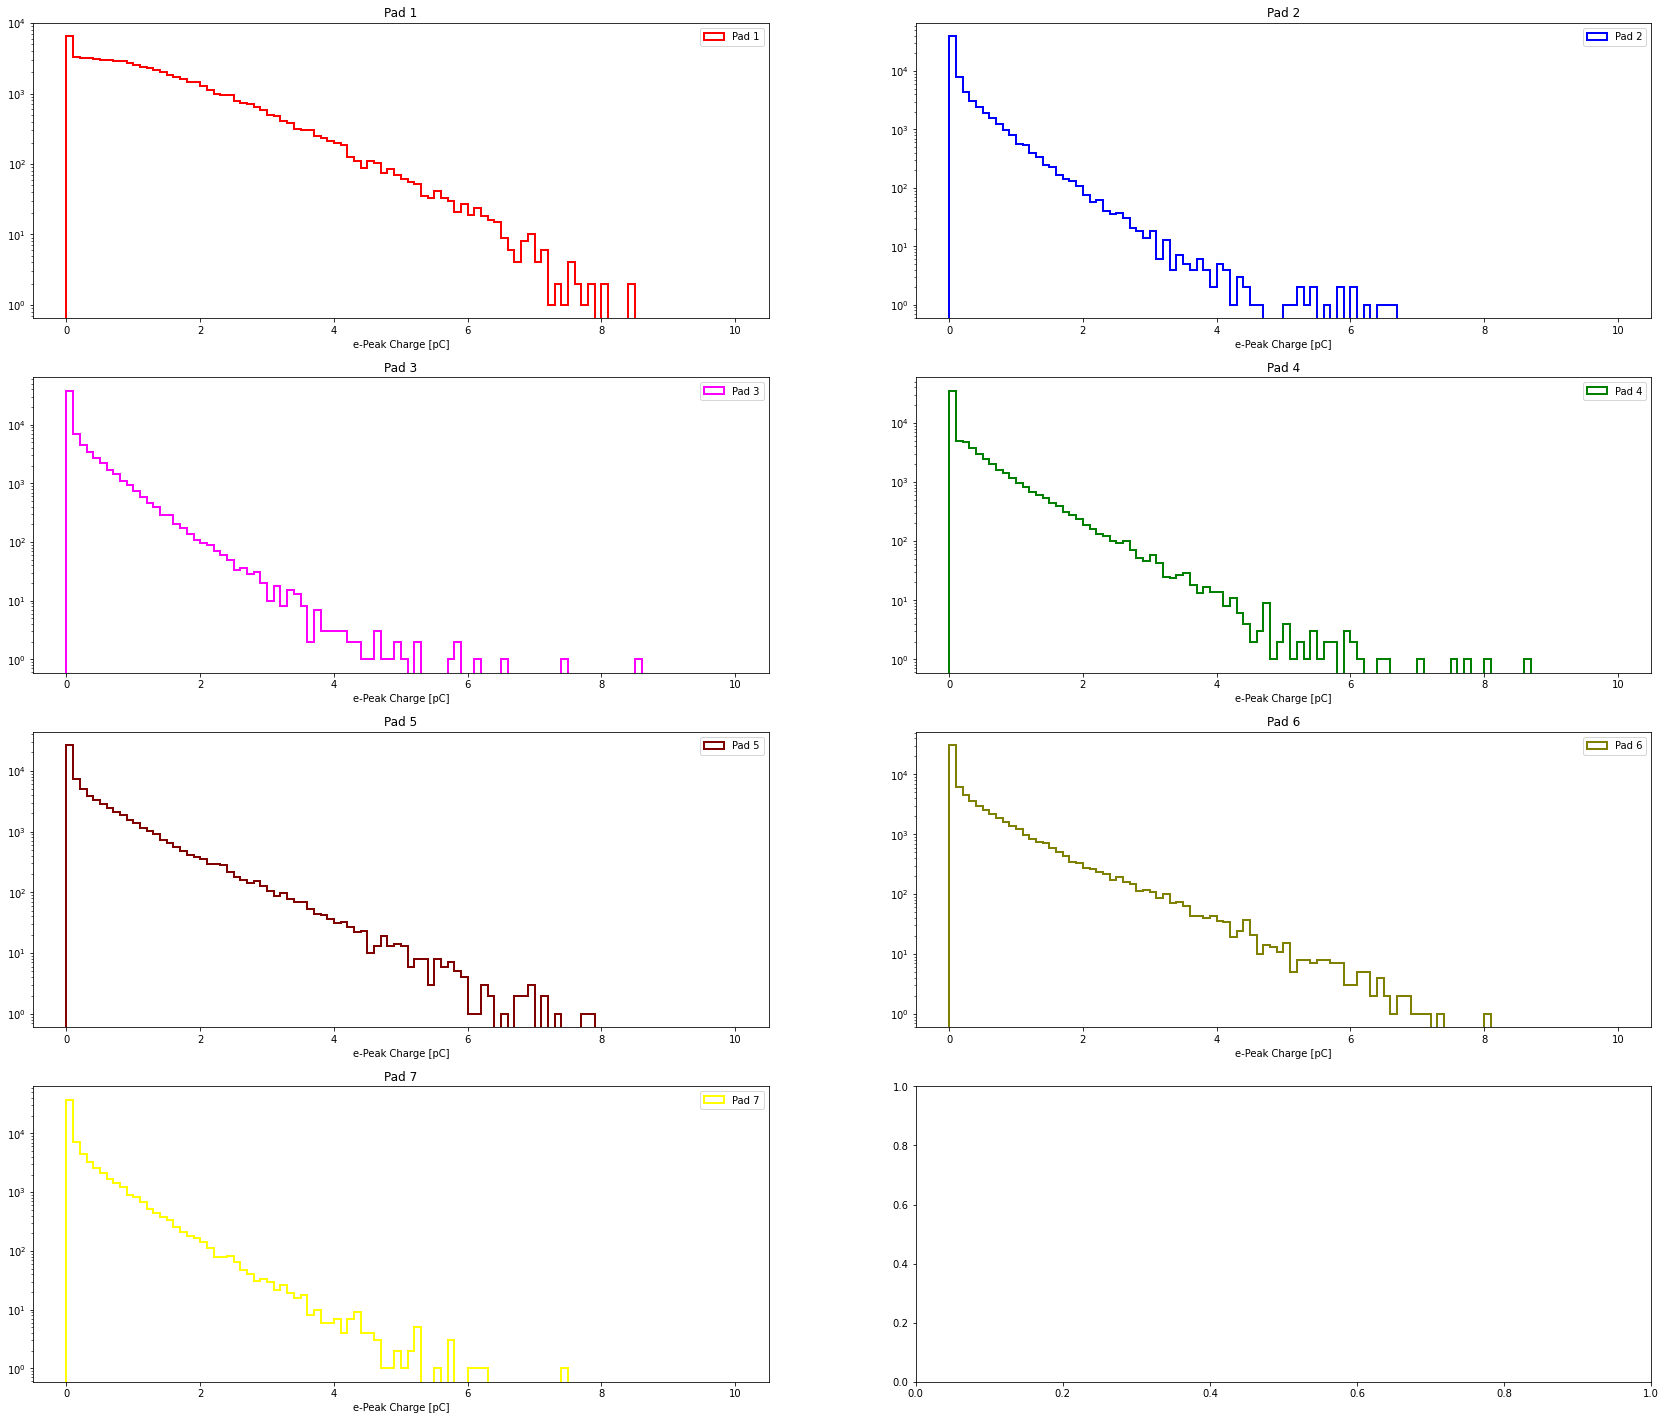

In [108]:
fig, axs = plt.subplots(4,2,figsize=(29, 25))
axs=axs.ravel()
for i in range(len(mm_vs)):
    axs[i].hist(mm_qes[i], bins=100, range=(0.0, 10), histtype='step', color=colors[i], lw=2, label=f'Pad {i+1}')
    axs[i].set_yscale('log')
    axs[i].set_xlabel('e-Peak Charge [pC]')
    axs[i].set_title(f'Pad {i+1}')
    axs[i].legend()
plt.show()

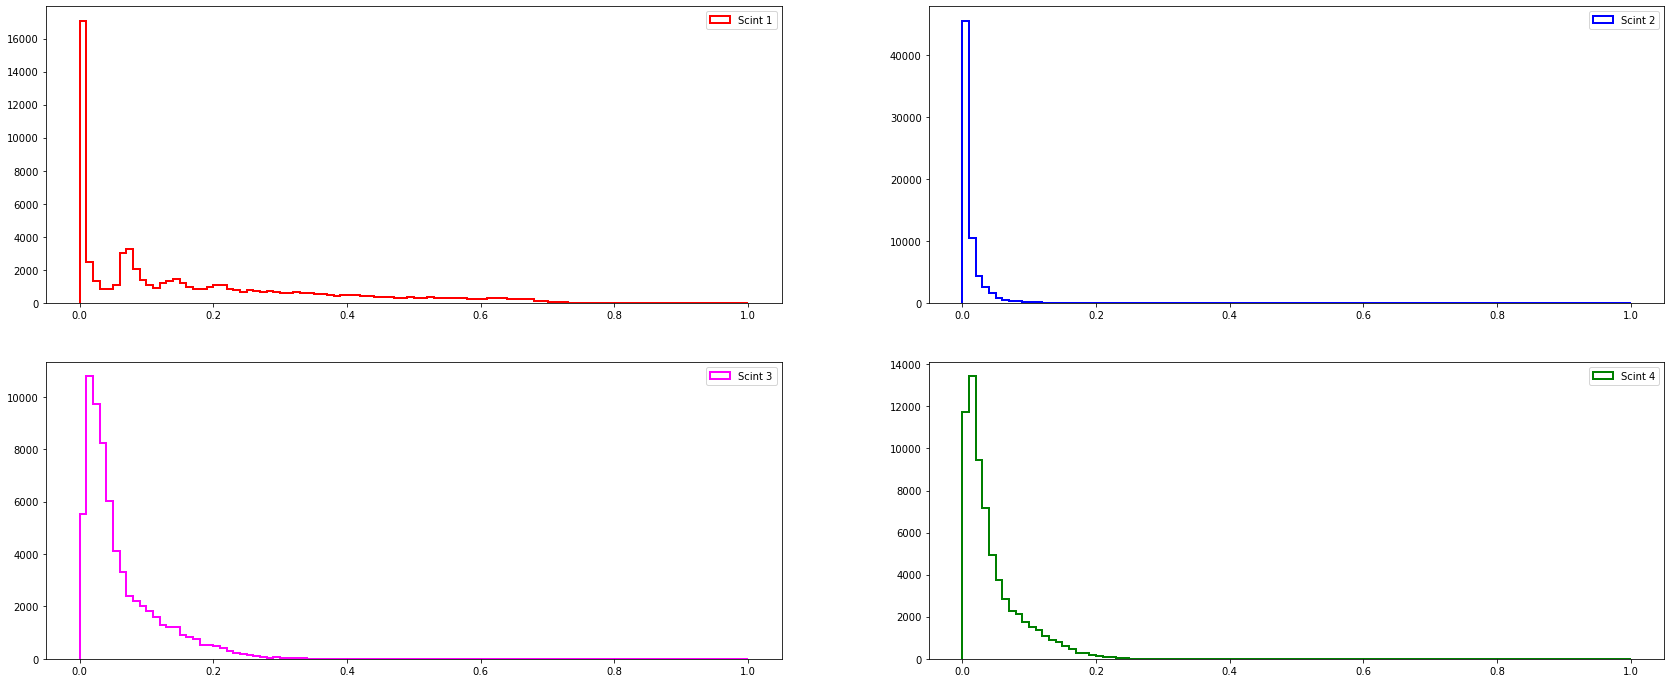

In [109]:
fig, axs = plt.subplots(2, 2, figsize=(29, 12))
axs=axs.ravel()
for i in range(len(ss_v)):
    axs[i].hist(ss_v[i], bins=100, range=(0.0, 1), histtype='step', color=colors[i], lw=2, label=f'Scint {i+1}')
#     axs[i].set_yscale('log')
#     axs[i].set_xlabel('e-Peak Charge [pC]')
#     axs[i].set_title(f'Pad {i+1}')
    axs[i].legend()
plt.show()

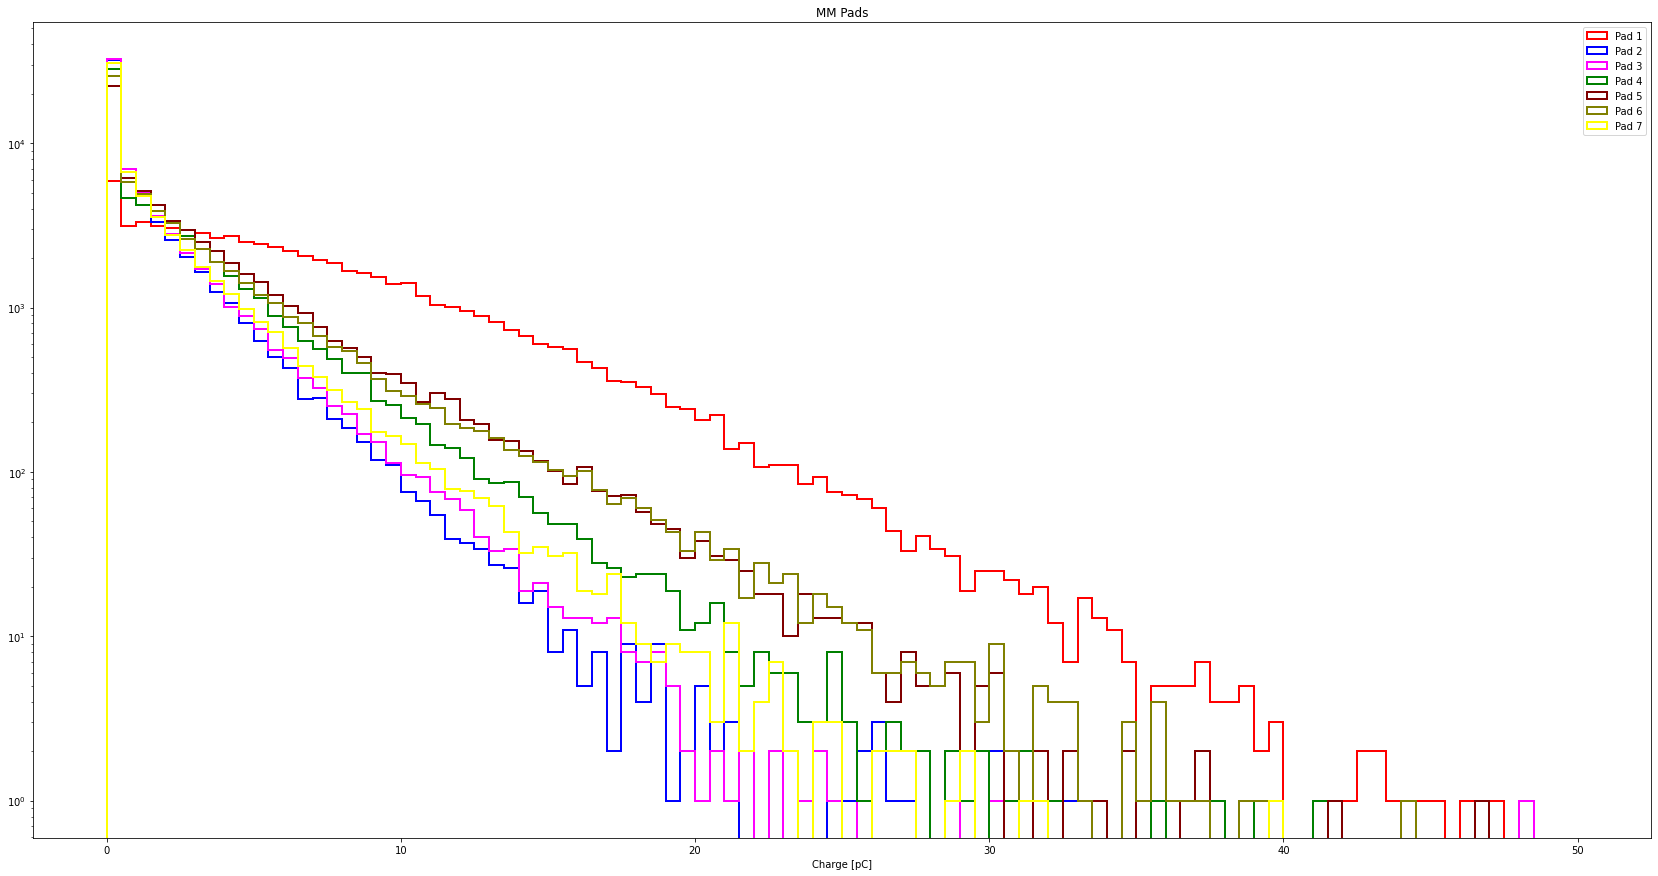

In [110]:
fig, axs = plt.subplots(figsize=(29, 15))
for i in range(len(mm_vs)):
    axs.hist(mm_qalls[i], bins=100, range=(0.0, 50), histtype='step', color=colors[i], lw=2, label=f'Pad {i+1}')
axs.set_yscale('log')
axs.set_xlabel('Charge [pC]')
axs.set_title('MM Pads')
axs.legend()
plt.show()

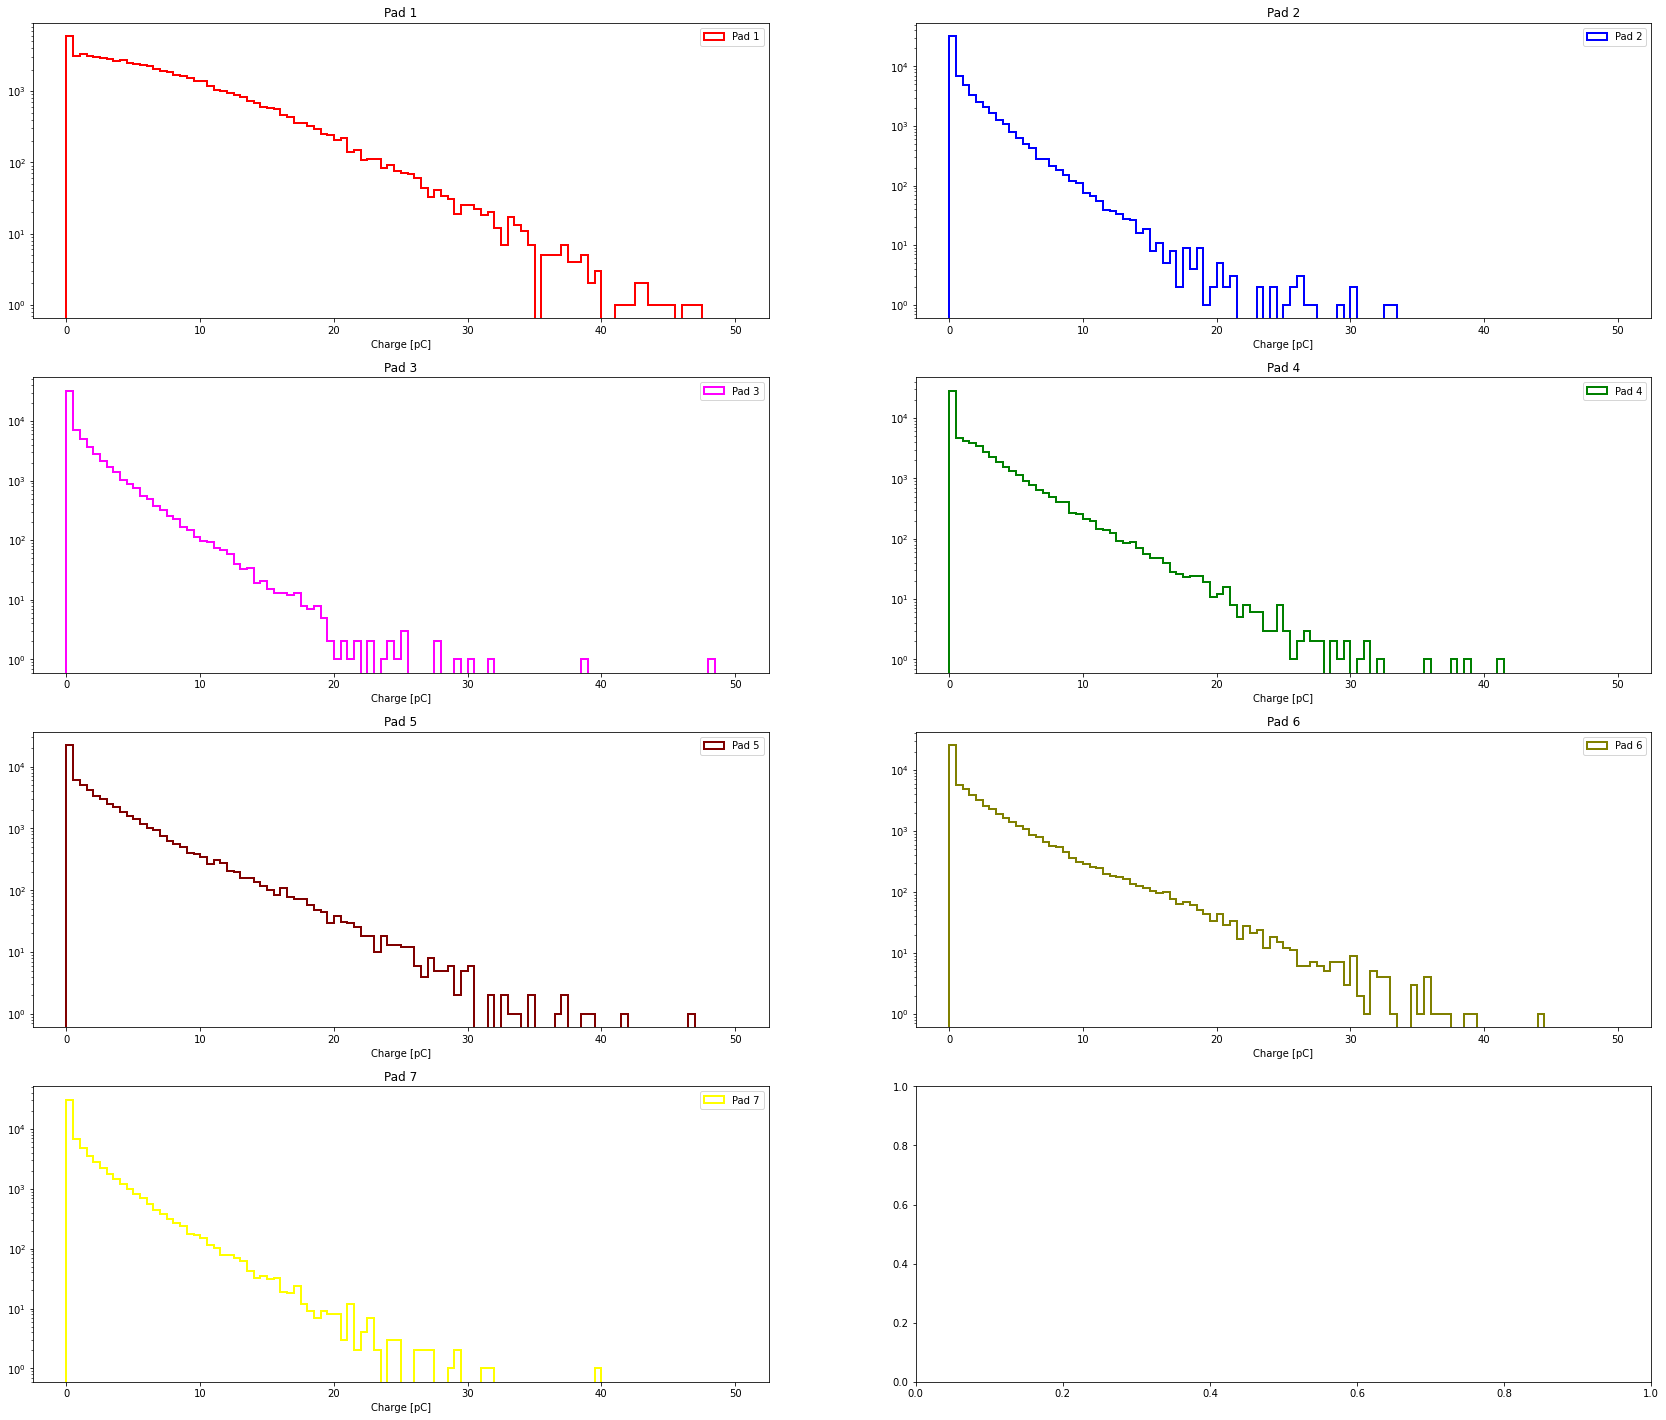

In [111]:
fig, axs = plt.subplots(4,2,figsize=(29, 25))
axs=axs.ravel()
for i in range(len(mm_vs)):
    axs[i].hist(mm_qalls[i], bins=100, range=(0.0, 50), histtype='step', color=colors[i], lw=2, label=f'Pad {i+1}')
    axs[i].set_yscale('log')
    axs[i].set_xlabel('Charge [pC]')
    axs[i].set_title(f'Pad {i+1}')
    axs[i].legend()
plt.show()

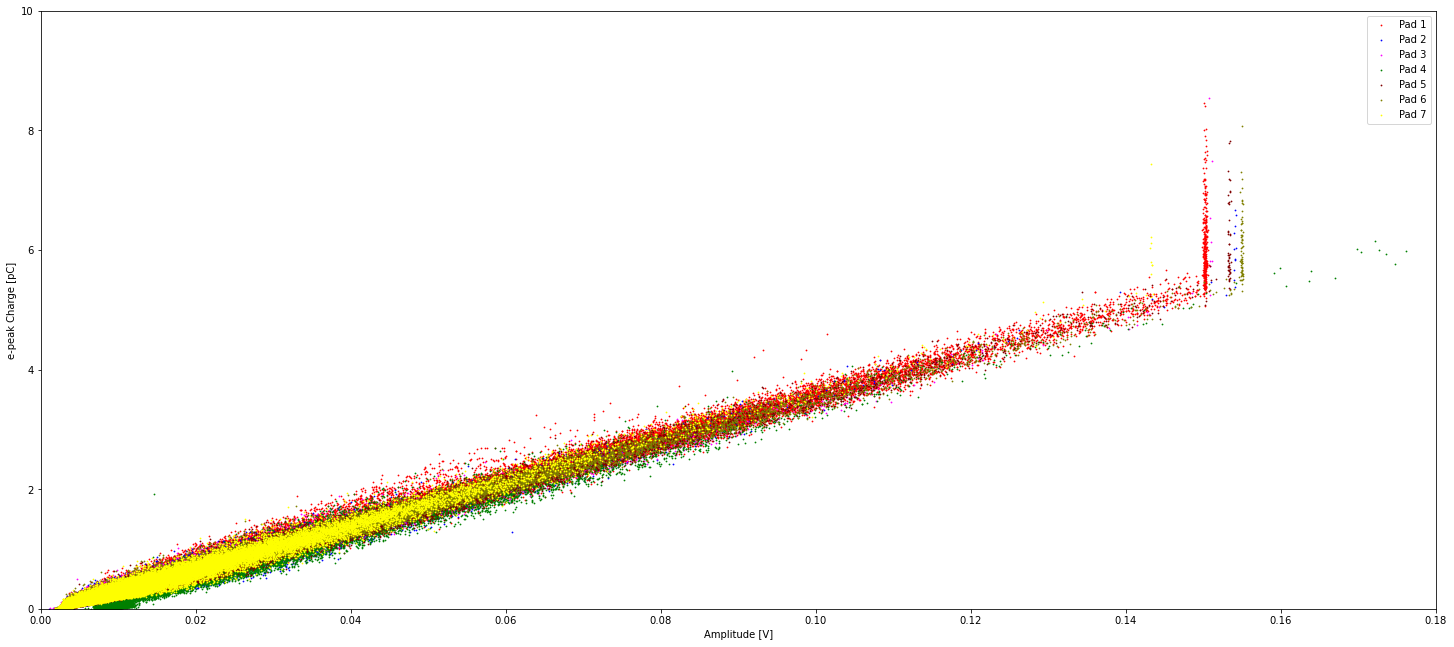

In [113]:
fig, axs = plt.subplots(figsize=(25, 11))

for i in range(len(mm_vs)):
    axs.scatter(mm_vs[i], mm_qes[i], s=0.6, color=colors[i], label=f'Pad {i+1}')
    
axs.set_xlabel('Amplitude [V]')
axs.set_ylabel('e-peak Charge [pC]')
axs.set_xlim(0, 0.18)
axs.set_ylim(0, 10)
axs.legend()

plt.show()

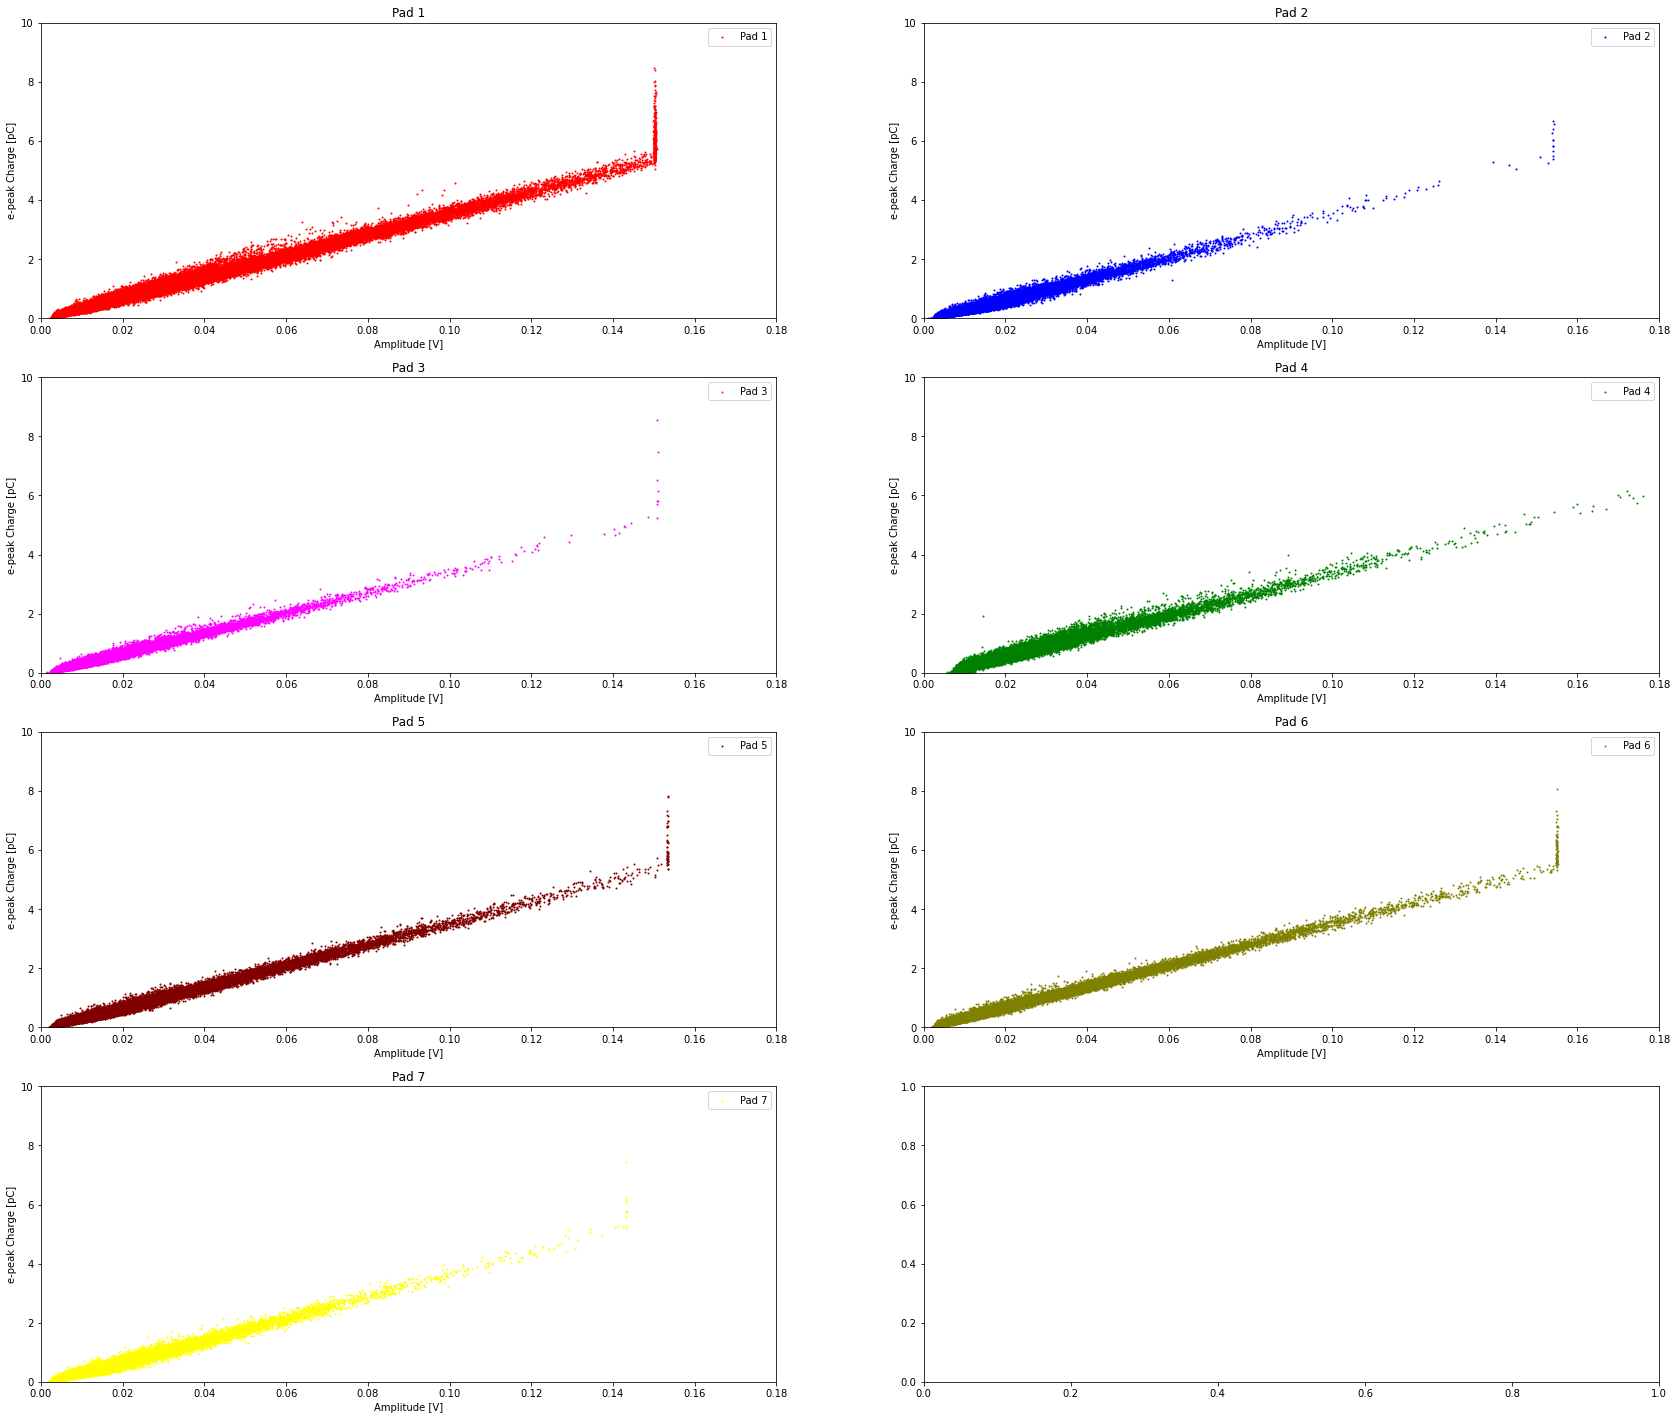

In [114]:
fig, axs = plt.subplots(4,2,figsize=(29, 25))
axs=axs.ravel()
for i in range(len(mm_vs)):
    axs[i].scatter(mm_vs[i], mm_qes[i], s=1, color=colors[i], label=f'Pad {i+1}')
    
    axs[i].set_xlabel('Amplitude [V]')
    axs[i].set_ylabel('e-peak Charge [pC]')
    axs[i].set_xlim(0, 0.18)
    axs[i].set_ylim(0, 10)
    axs[i].legend()
    axs[i].set_title(f'Pad {i+1}')

plt.show()

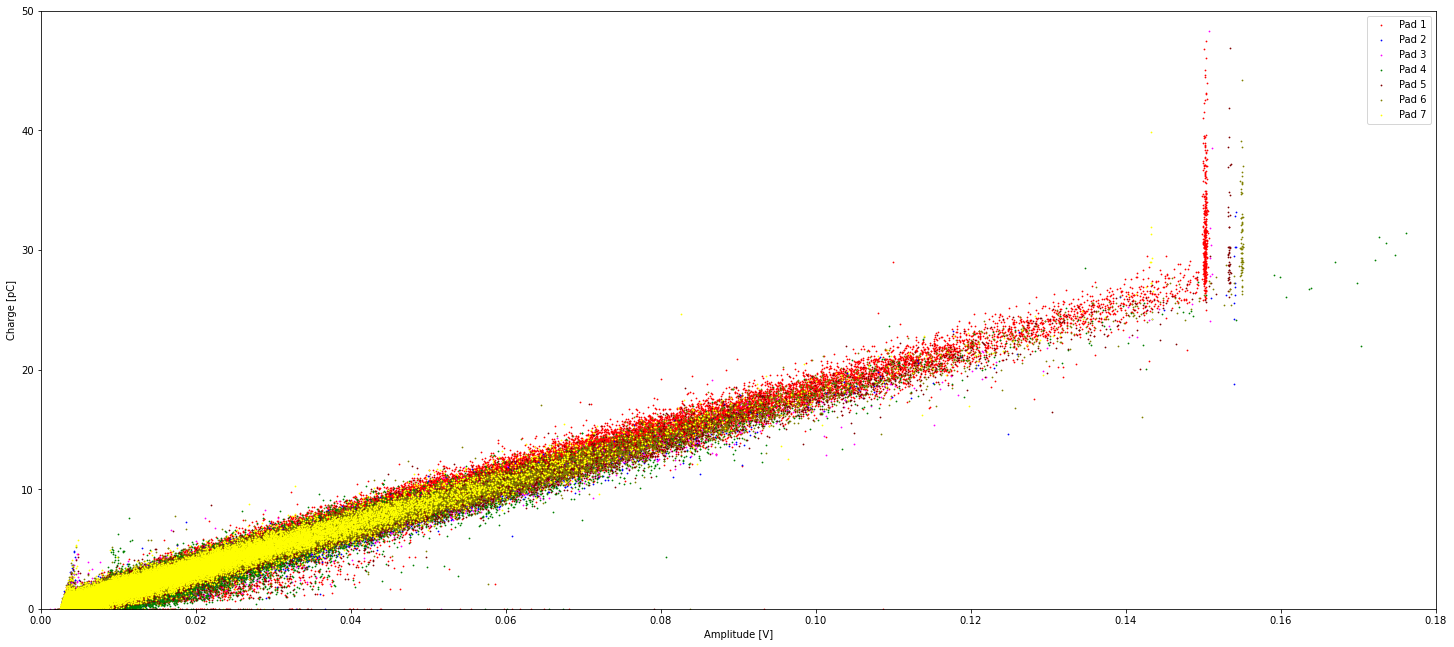

In [115]:
fig, axs = plt.subplots(figsize=(25, 11))

for i in range(len(mm_vs)):
    axs.scatter(mm_vs[i], mm_qalls[i], s=0.6, color=colors[i], label=f'Pad {i+1}')
    
axs.set_xlabel('Amplitude [V]')
axs.set_ylabel('Charge [pC]')
axs.set_xlim(0, 0.18)
axs.set_ylim(0, 50)
axs.legend()

plt.show()

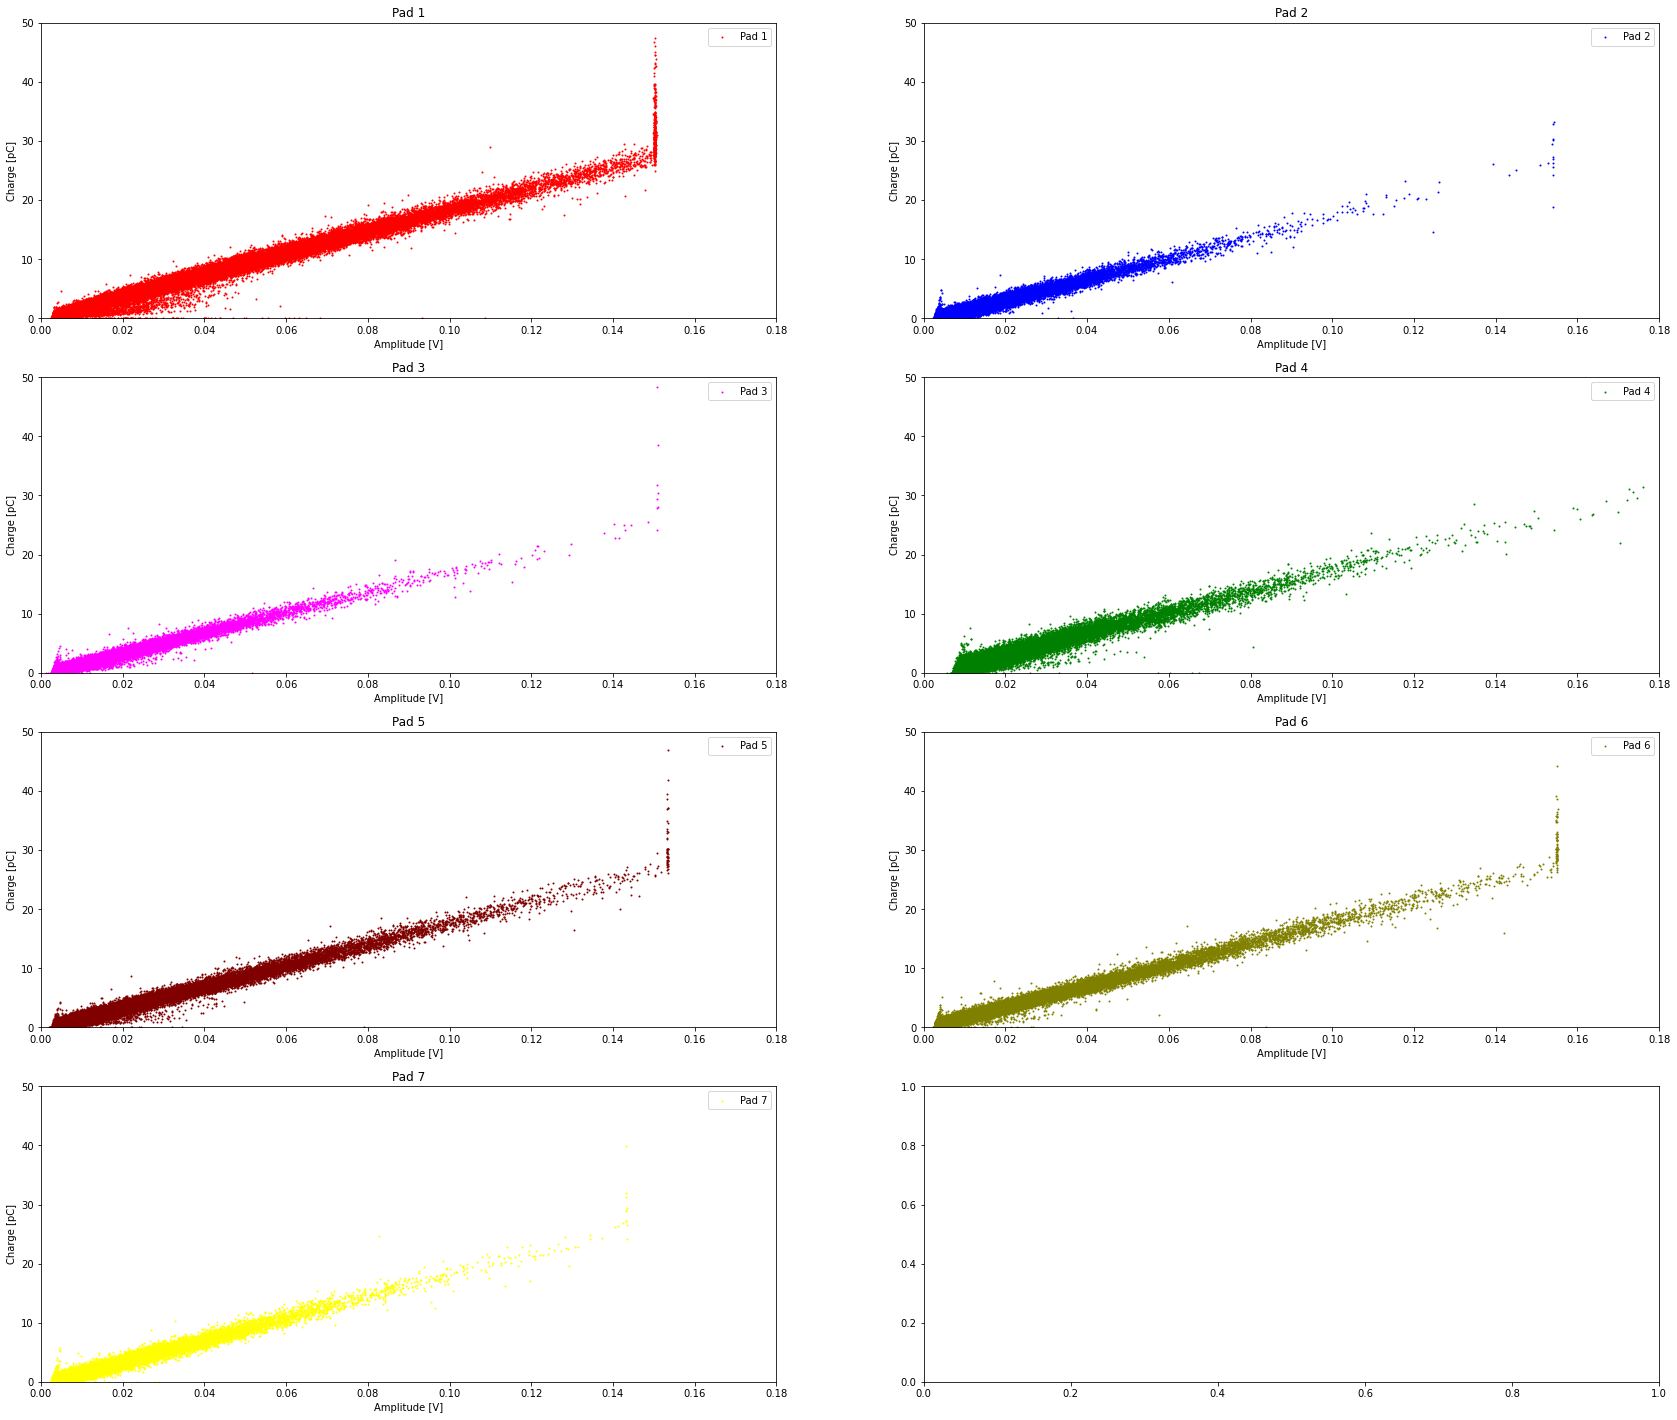

In [116]:
fig, axs = plt.subplots(4,2,figsize=(29, 25))
axs=axs.ravel()
for i in range(len(mm_vs)):
    axs[i].scatter(mm_vs[i], mm_qalls[i], s=1, color=colors[i], label=f'Pad {i+1}')
    
    axs[i].set_xlabel('Amplitude [V]')
    axs[i].set_ylabel('Charge [pC]')
    axs[i].set_xlim(0, 0.18)
    axs[i].set_ylim(0, 50)
    axs[i].legend()
    axs[i].set_title(f'Pad {i+1}')

plt.show()

In [117]:
mm1_cut = np.logical_and((mm1_v > 0.025),(mm1_v < 0.17))
mm2_cut = np.logical_and((mm2_v > 0.025),(mm2_v < 0.17))
mm3_cut = np.logical_and((mm3_v > 0.025),(mm3_v < 0.17))
mm4_cut = np.logical_and((mm4_v > 0.025),(mm4_v < 0.17))
mm5_cut = np.logical_and((mm5_v > 0.025),(mm5_v < 0.17))
mm6_cut = np.logical_and((mm6_v > 0.025),(mm6_v < 0.17))
mm7_cut = np.logical_and((mm7_v > 0.025),(mm7_v < 0.17))

mmx_cut = [mm1_cut,mm2_cut,mm3_cut,mm4_cut,mm5_cut,mm6_cut,mm7_cut]

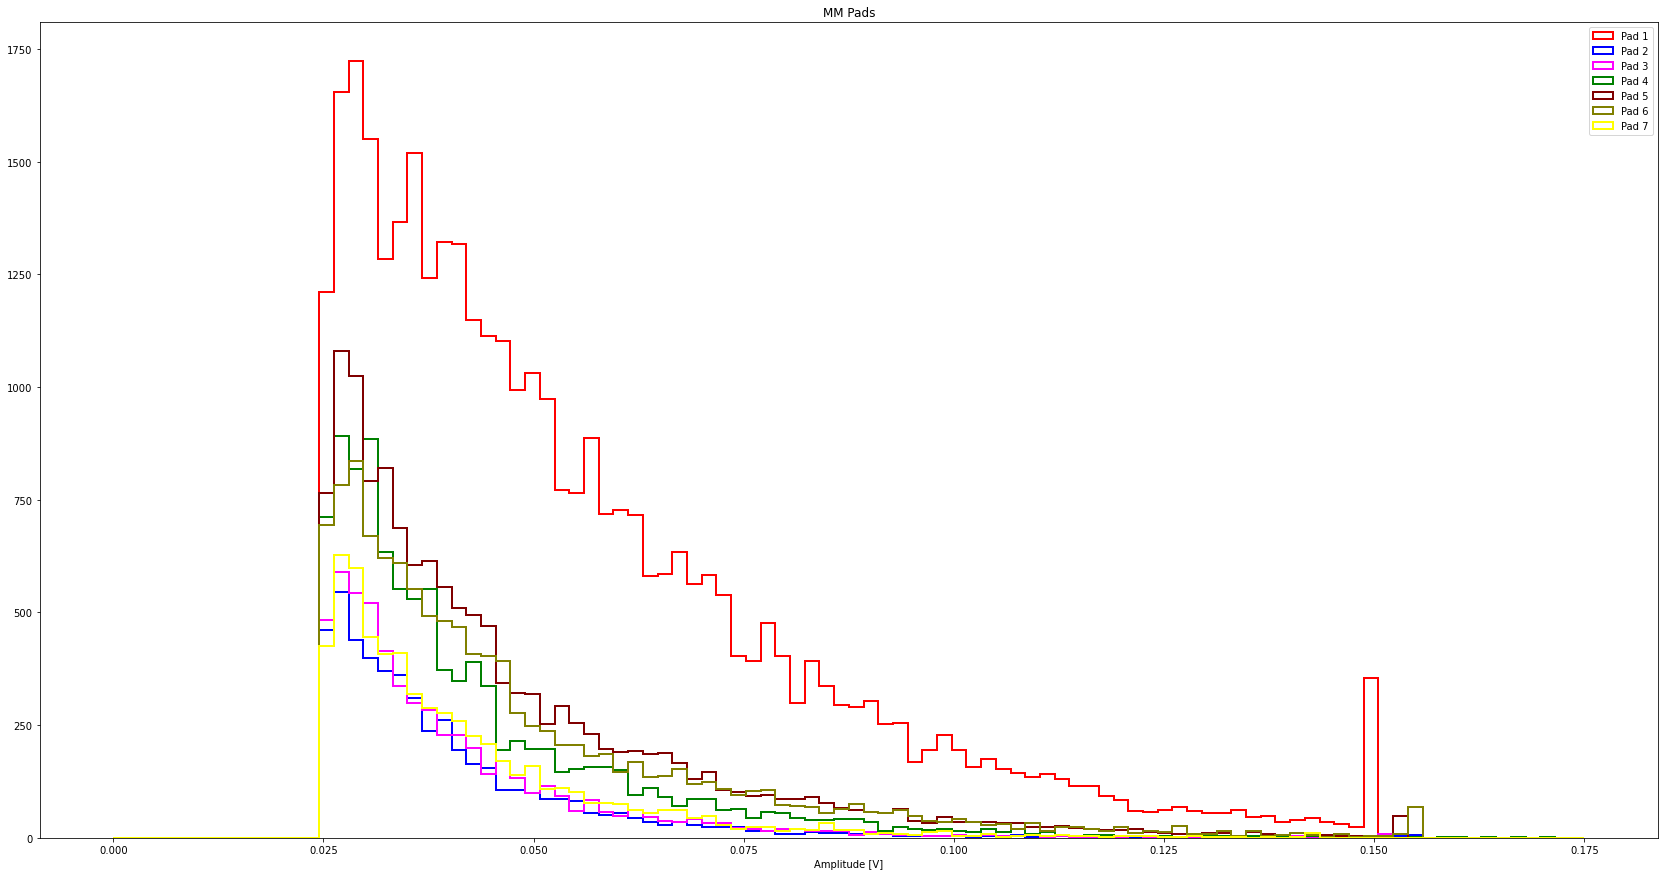

In [118]:
fig, axs = plt.subplots(figsize=(29, 15))
for i in range(len(mm_vs)):
    axs.hist(mm_vs[i][mmx_cut[i]], bins=100, range=(0.0, 0.175), histtype='step', color=colors[i], lw=2, label=f'Pad {i+1}')
# axs.set_yscale('log')
axs.set_xlabel('Amplitude [V]')
axs.set_title('MM Pads')
axs.legend()
plt.show()

In [119]:
mcp1_cut = np.logical_and((mcp1_v > 0.15),(mcp1_v < 0.7))
mcp2_cut = np.logical_and((mcp2_v > 0.15),(mcp2_v < 0.7))
mcp3_cut = np.logical_and((mcp3_v > 0.15),(mcp3_v < 0.7))
mcp4_cut = np.logical_and((mcp4_v > 0.15),(mcp4_v < 0.7))

mm1_cut = np.logical_and((mm1_v > 0.02),(mm1_v < 0.17))
mm2_cut = np.logical_and((mm2_v > 0.02),(mm2_v < 0.17))
mm3_cut = np.logical_and((mm3_v > 0.02),(mm3_v < 0.17))
mm4_cut = np.logical_and((mm4_v > 0.02),(mm4_v < 0.17))
mm5_cut = np.logical_and((mm5_v > 0.02),(mm5_v < 0.17))
mm6_cut = np.logical_and((mm6_v > 0.02),(mm6_v < 0.17))
mm7_cut = np.logical_and((mm7_v > 0.02),(mm7_v < 0.17))

cc1 = np.logical_and(mcp1_cut, mm1_cut)
cc2 = np.logical_and(mcp1_cut, mm2_cut)
cc3 = np.logical_and(mcp2_cut, mm3_cut)
cc4 = np.logical_and(mcp2_cut, mm4_cut)
cc5 = np.logical_and(mcp3_cut, mm5_cut)
cc6 = np.logical_and(mcp3_cut, mm6_cut)
cc7 = np.logical_and(mcp4_cut, mm7_cut)

mm_cuts = [mm1_cut,mm2_cut,mm3_cut,mm4_cut,mm5_cut,mm6_cut,mm7_cut]

array([289.57614387, 631.68287551, -11.30743009, ..., -11.21953865,
       -11.28650299, -11.25291084])

In [120]:
tranges = [
    [-8000,-7300],
    [-12700, -12000],
    [-12700, -12000],
    [-8200,-7000],
    [-2700, 1000],
    [-12700, 10000],
    [-9000,-8200],
]

 FCN=1211.57 FROM MIGRAD    STATUS=CONVERGED      75 CALLS          76 TOTAL
                     EDM=1.47158e-10    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     3.24917e+03   2.22168e+01   2.75674e-01   3.17408e-07
   2  Mean        -7.63467e+03   1.75018e-01   3.64049e-03  -5.62608e-05
   3  Sigma        3.45172e+01   1.61339e-01   1.79972e-05  -6.91229e-03
 FCN=156.3 FROM MIGRAD    STATUS=CONVERGED      63 CALLS          64 TOTAL
                     EDM=1.11881e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     4.83913e+02   7.40858e+00   3.41736e-02  -1.42225e-05
   2  Mean        -1.23626e+04   5.07013e-01   5.89493e-03   5.09103e-04
   3  Sigma        4.34114e+01   4.

Warning in <TCanvas::Constructor>: Deleting canvas with same name: cc
Warning in <TROOT::Append>: Replacing existing TH1: ht1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: ht2 (Potential memory leak).


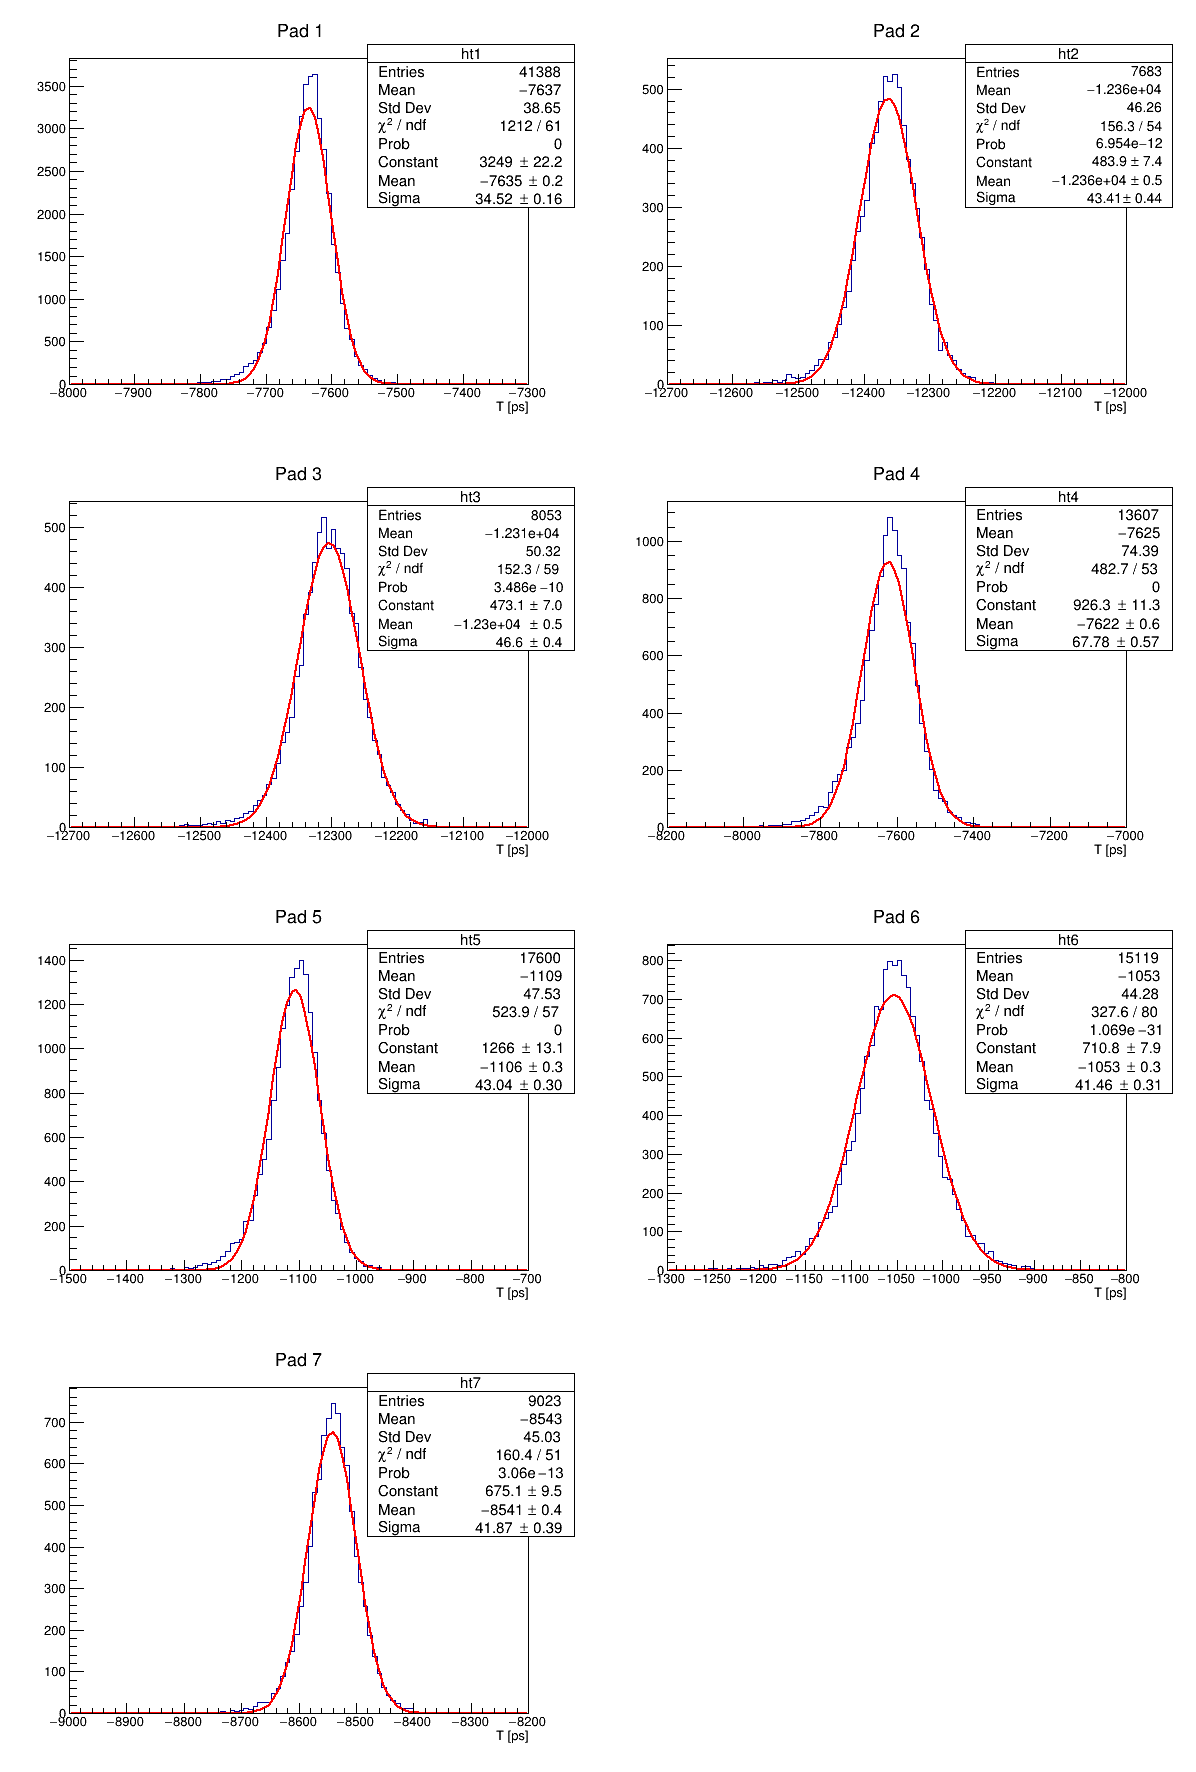

In [121]:
ROOT.gStyle.SetOptFit(1111)
c = ROOT.TCanvas("cc", '', 1200, 1800)
c.Divide(2, 4)

ht1 = ROOT.TH1D('ht1', f'{pnames[0]};T [ps]', 100, -8000,-7300)
ht1.FillN(np.count_nonzero(mm1_cut), 1e3*dt1[mm1_cut], 0, 1)

ht2 = ROOT.TH1D('ht2', f'{pnames[1]};T [ps]', 100, -12700, -12000)
ht2.FillN(np.count_nonzero(mm2_cut), 1e3*dt2[mm2_cut], 0, 1)

ht3 = ROOT.TH1D('ht3', f'{pnames[2]};T [ps]', 100, -12700, -12000)
ht3.FillN(np.count_nonzero(mm3_cut), 1e3*dt3[mm3_cut], 0, 1)

ht4 = ROOT.TH1D('ht4', f'{pnames[3]};T [ps]', 100, -8200,-7000)
ht4.FillN(np.count_nonzero(mm4_cut), 1e3*dt4[mm4_cut], 0, 1)

ht5 = ROOT.TH1D('ht5', f'{pnames[4]};T [ps]', 100, -1500, -700)
ht5.FillN(np.count_nonzero(mm5_cut), 1e3*dt5[mm5_cut], 0, 1)

ht6 = ROOT.TH1D('ht6', f'{pnames[5]};T [ps]', 100,-1300, -800)
ht6.FillN(np.count_nonzero(mm6_cut), 1e3*dt6[mm6_cut], 0, 1)

ht7 = ROOT.TH1D('ht7', f'{pnames[6]};T [ps]', 100,-9000,-8200)
ht7.FillN(np.count_nonzero(mm7_cut), 1e3*dt7[mm7_cut], 0, 1)

c.cd(1)
ht1.Draw()
ht1.Fit('gaus')

c.cd(2)
ht2.Draw()
ht2.Fit('gaus')

c.cd(3)
ht3.Draw()
ht3.Fit('gaus')

c.cd(4)
ht4.Draw()
ht4.Fit('gaus')

c.cd(5)
ht5.Draw()
ht5.Fit('gaus')

c.cd(6)
ht6.Draw()
ht6.Fit('gaus')

c.cd(7)
ht7.Draw()
ht7.Fit('gaus')

c.Draw()

 FCN=1151.38 FROM MIGRAD    STATUS=CONVERGED      77 CALLS          78 TOTAL
                     EDM=1.52388e-10    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     3.07484e+03   2.16870e+01   2.61922e-01   3.32690e-07
   2  Mean        -7.63441e+03   1.79582e-01   3.64037e-03  -5.52823e-05
   3  Sigma        3.43891e+01   1.66100e-01   1.81051e-05  -6.81111e-03
 FCN=141.313 FROM MIGRAD    STATUS=CONVERGED      63 CALLS          64 TOTAL
                     EDM=1.07498e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     4.48604e+02   7.08674e+00   3.12346e-02  -1.39138e-05
   2  Mean        -1.23623e+04   5.27745e-01   5.89480e-03   5.17290e-04
   3  Sigma        4.35848e+01   

Warning in <TCanvas::Constructor>: Deleting canvas with same name: cc
Warning in <TROOT::Append>: Replacing existing TH1: ht1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: ht2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: ht3 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: ht4 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: ht5 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: ht6 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: ht7 (Potential memory leak).


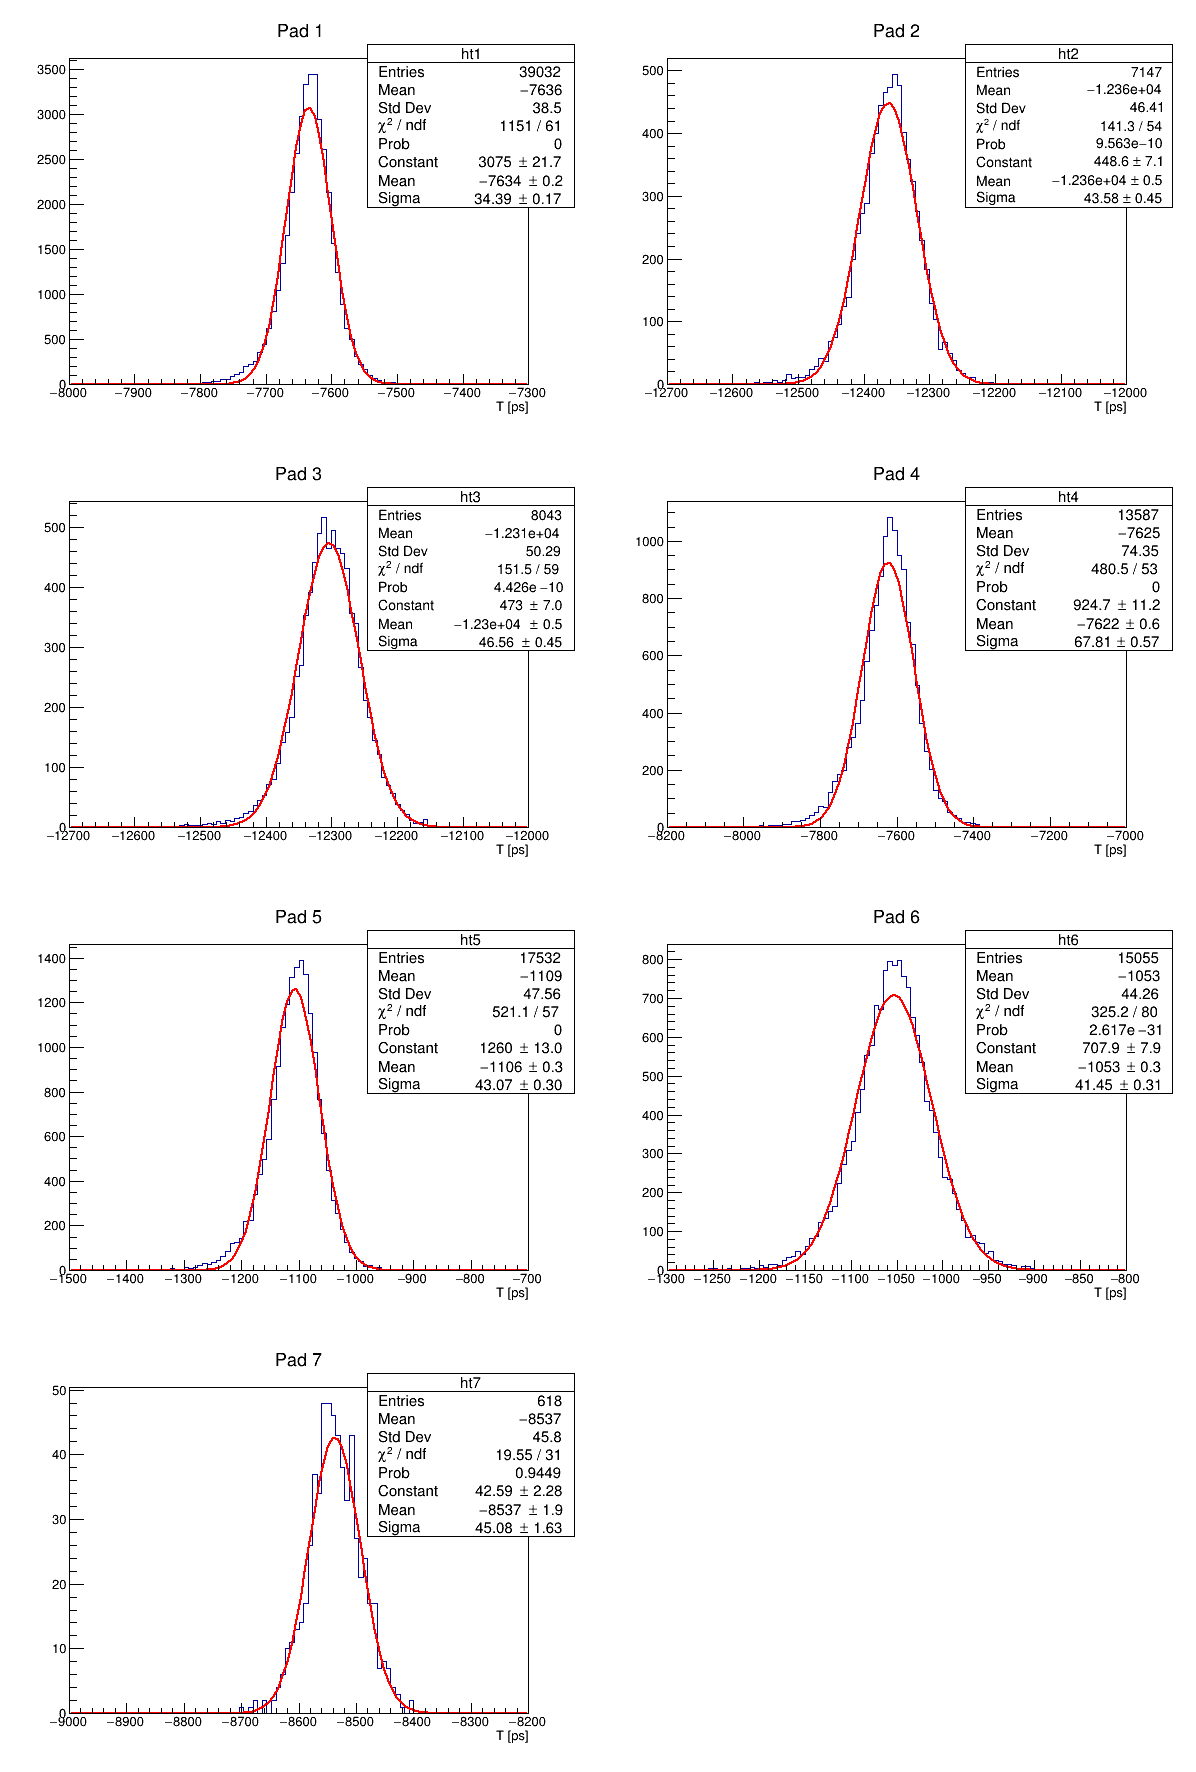

In [43]:
ROOT.gStyle.SetOptFit(1111)
c = ROOT.TCanvas("cc", '', 1200, 1800)
c.Divide(2, 4)

ht1 = ROOT.TH1D('ht1', f'{pnames[0]};T [ps]', 100, -8000,-7300)
ht1.FillN(np.count_nonzero(cc1), 1e3*dt1[cc1], 0, 1)

ht2 = ROOT.TH1D('ht2', f'{pnames[1]};T [ps]', 100, -12700, -12000)
ht2.FillN(np.count_nonzero(cc2), 1e3*dt2[cc2], 0, 1)

ht3 = ROOT.TH1D('ht3', f'{pnames[2]};T [ps]', 100, -12700, -12000)
ht3.FillN(np.count_nonzero(cc3), 1e3*dt3[cc3], 0, 1)

ht4 = ROOT.TH1D('ht4', f'{pnames[3]};T [ps]', 100, -8200,-7000)
ht4.FillN(np.count_nonzero(cc4), 1e3*dt4[cc4], 0, 1)

ht5 = ROOT.TH1D('ht5', f'{pnames[4]};T [ps]', 100, -1500, -700)
ht5.FillN(np.count_nonzero(cc5), 1e3*dt5[cc5], 0, 1)

ht6 = ROOT.TH1D('ht6', f'{pnames[5]};T [ps]', 100,-1300, -800)
ht6.FillN(np.count_nonzero(cc6), 1e3*dt6[cc6], 0, 1)

ht7 = ROOT.TH1D('ht7', f'{pnames[6]};T [ps]', 100,-9000,-8200)
ht7.FillN(np.count_nonzero(cc7), 1e3*dt7[cc7], 0, 1)

c.cd(1)
ht1.Draw()
ht1.Fit('gaus')

c.cd(2)
ht2.Draw()
ht2.Fit('gaus')

c.cd(3)
ht3.Draw()
ht3.Fit('gaus')

c.cd(4)
ht4.Draw()
ht4.Fit('gaus')

c.cd(5)
ht5.Draw()
ht5.Fit('gaus')

c.cd(6)
ht6.Draw()
ht6.Fit('gaus')

c.cd(7)
ht7.Draw()
ht7.Fit('gaus')

c.Draw()

In [122]:
# vv_thr = 0.02

# xyc1 = np.where(np.logical_and(mm1_cut, mm1_v > vv_thr)*(mm1_qall < 200))


# qq_thr = 5

# xyq1 = np.where(np.logical_and(mm1_cut, mm1_qall > qq_thr))

qq_thr = 7

# xyq1 = np.where(np.logical_and(mm1_cut, mm1_qall > qq_thr))
# xyq2 = np.where(np.logical_and(mm2_cut, mm2_qall > qq_thr))
# xyq3 = np.where(np.logical_and(mm3_cut, mm3_qall > qq_thr))
# xyq4 = np.where(np.logical_and(mm4_cut, mm4_qall > qq_thr))
# xyq5 = np.where(np.logical_and(mm5_cut, mm5_qall > qq_thr))
# xyq6 = np.where(np.logical_and(mm6_cut, mm6_qall > qq_thr))
# xyq7 = np.where(np.logical_and(mm7_cut, mm7_qall > qq_thr))

xyq1 = np.where(np.logical_and(cc1, mm1_qall > qq_thr))
xyq2 = np.where(np.logical_and(cc2, mm2_qall > qq_thr))
xyq3 = np.where(np.logical_and(cc3, mm3_qall > qq_thr))
xyq4 = np.where(np.logical_and(cc4, mm4_qall > qq_thr))
xyq5 = np.where(np.logical_and(cc5, mm5_qall > qq_thr))
xyq6 = np.where(np.logical_and(cc6, mm6_qall > qq_thr))
xyq7 = np.where(np.logical_and(cc7, mm7_qall > qq_thr))

 FCN=560.453 FROM MIGRAD    STATUS=CONVERGED      73 CALLS          74 TOTAL
                     EDM=1.45382e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     2.31268e+03   1.99140e+01   1.75653e-01   6.28596e-07
   2  Mean        -7.63398e+03   1.89168e-01   3.64016e-03  -2.42960e-04
   3  Sigma        2.80203e+01   1.56150e-01   1.50901e-05  -1.79488e-02
 FCN=75.3125 FROM MIGRAD    STATUS=CONVERGED      74 CALLS          75 TOTAL
                     EDM=1.99498e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.26932e+02   4.44864e+00   1.48257e-02  -1.23629e-07
   2  Mean        -1.23655e+04   8.37214e-01   5.89631e-03  -7.76172e-05
   3  Sigma        2.93656e+01   

Warning in <TCanvas::Constructor>: Deleting canvas with same name: cc
Warning in <TROOT::Append>: Replacing existing TH1: ht1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: ht2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: ht3 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: ht4 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: ht5 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: ht6 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: ht7 (Potential memory leak).


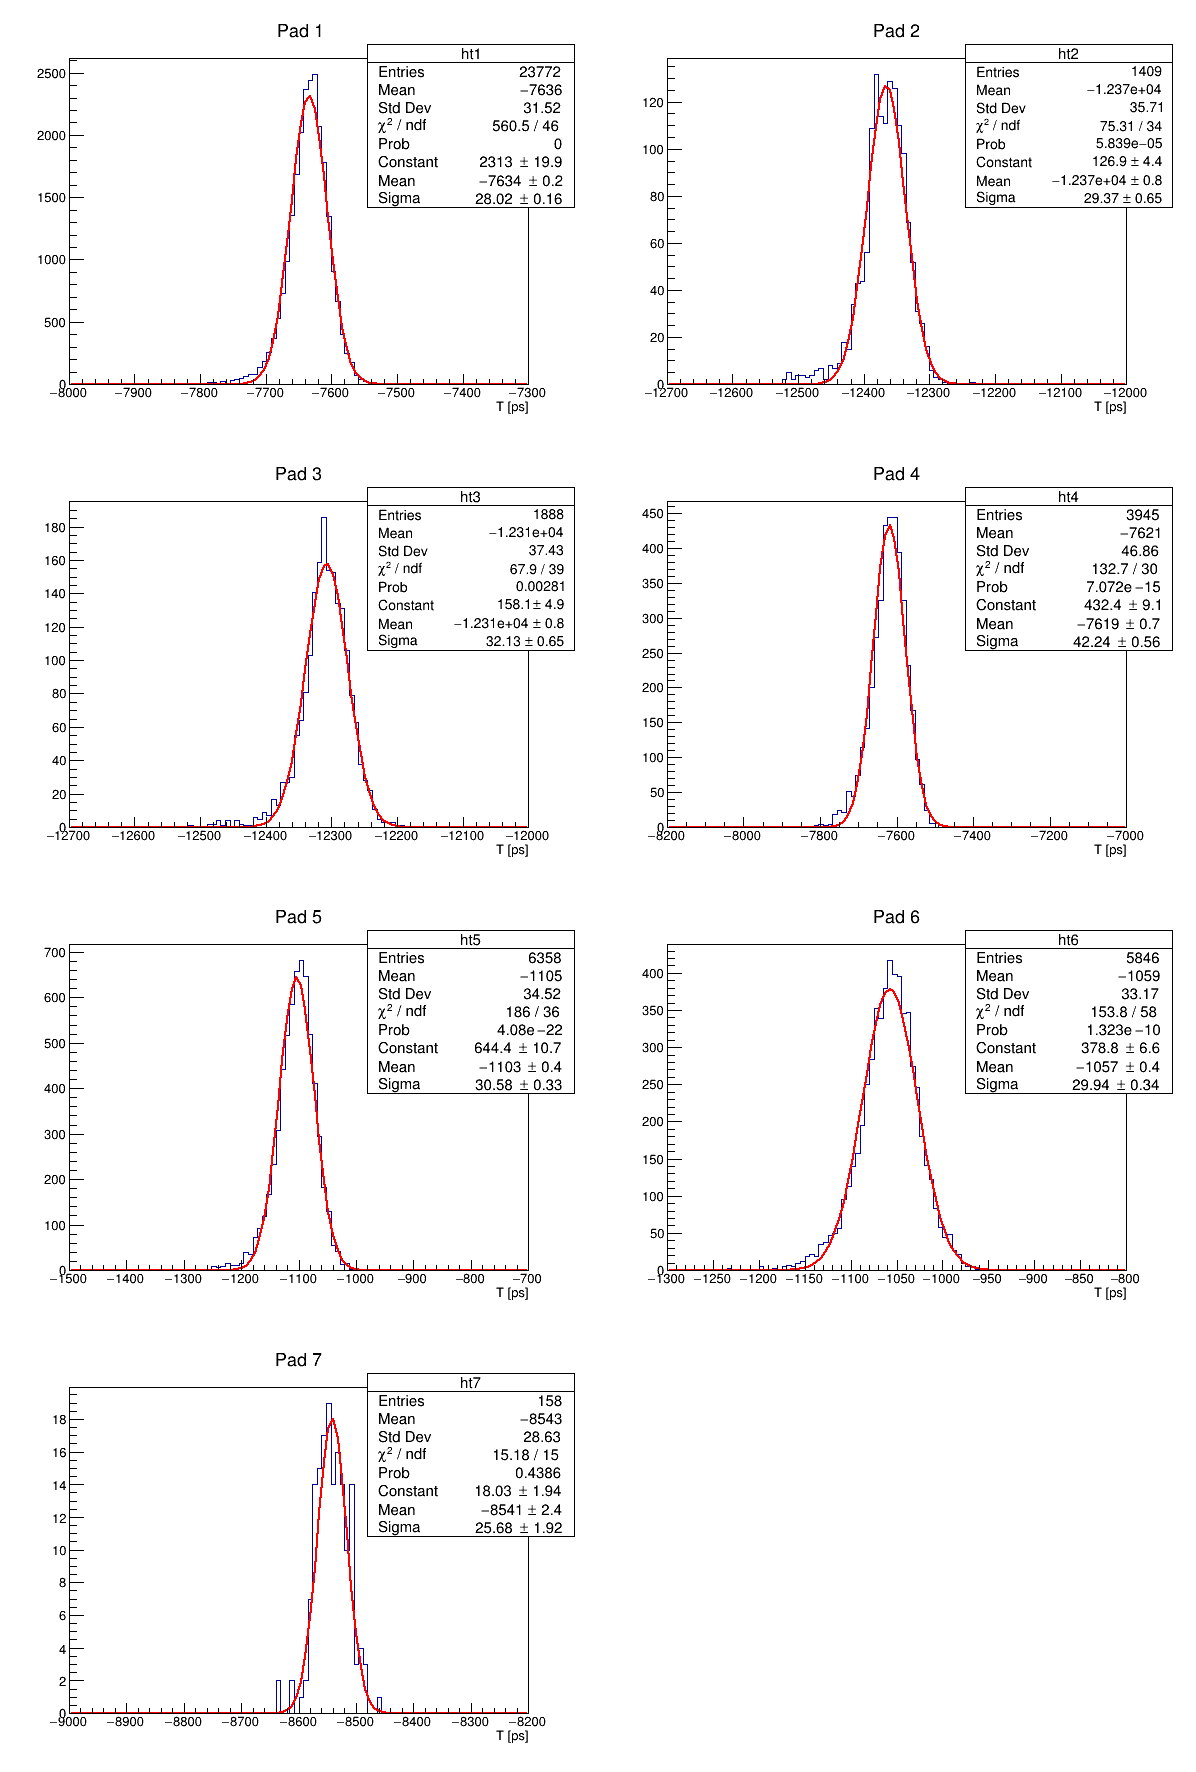

In [123]:
ROOT.gStyle.SetOptFit(1111)
c = ROOT.TCanvas("cc", '', 1200, 1800)
c.Divide(2, 4)

ht1 = ROOT.TH1D('ht1', f'{pnames[0]};T [ps]', 100, -8000,-7300)
ht1.FillN(np.count_nonzero(xyq1), 1e3*dt1[xyq1], 0, 1)

ht2 = ROOT.TH1D('ht2', f'{pnames[1]};T [ps]', 100, -12700, -12000)
ht2.FillN(np.count_nonzero(xyq2), 1e3*dt2[xyq2], 0, 1)

ht3 = ROOT.TH1D('ht3', f'{pnames[2]};T [ps]', 100, -12700, -12000)
ht3.FillN(np.count_nonzero(xyq3), 1e3*dt3[xyq3], 0, 1)

ht4 = ROOT.TH1D('ht4', f'{pnames[3]};T [ps]', 100, -8200,-7000)
ht4.FillN(np.count_nonzero(xyq4), 1e3*dt4[xyq4], 0, 1)

ht5 = ROOT.TH1D('ht5', f'{pnames[4]};T [ps]', 100, -1500, -700)
ht5.FillN(np.count_nonzero(xyq5), 1e3*dt5[xyq5], 0, 1)

ht6 = ROOT.TH1D('ht6', f'{pnames[5]};T [ps]', 100,-1300, -800)
ht6.FillN(np.count_nonzero(xyq6), 1e3*dt6[xyq6], 0, 1)

ht7 = ROOT.TH1D('ht7', f'{pnames[6]};T [ps]', 100,-9000,-8200)
ht7.FillN(np.count_nonzero(xyq7), 1e3*dt7[xyq7], 0, 1)

c.cd(1)
ht1.Draw()
ht1.Fit('gaus')

c.cd(2)
ht2.Draw()
ht2.Fit('gaus')

c.cd(3)
ht3.Draw()
ht3.Fit('gaus')

c.cd(4)
ht4.Draw()
ht4.Fit('gaus')

c.cd(5)
ht5.Draw()
ht5.Fit('gaus')

c.cd(6)
ht6.Draw()
ht6.Fit('gaus')

c.cd(7)
ht7.Draw()
ht7.Fit('gaus')

c.Draw()

NameError: name 'ntracks' is not defined

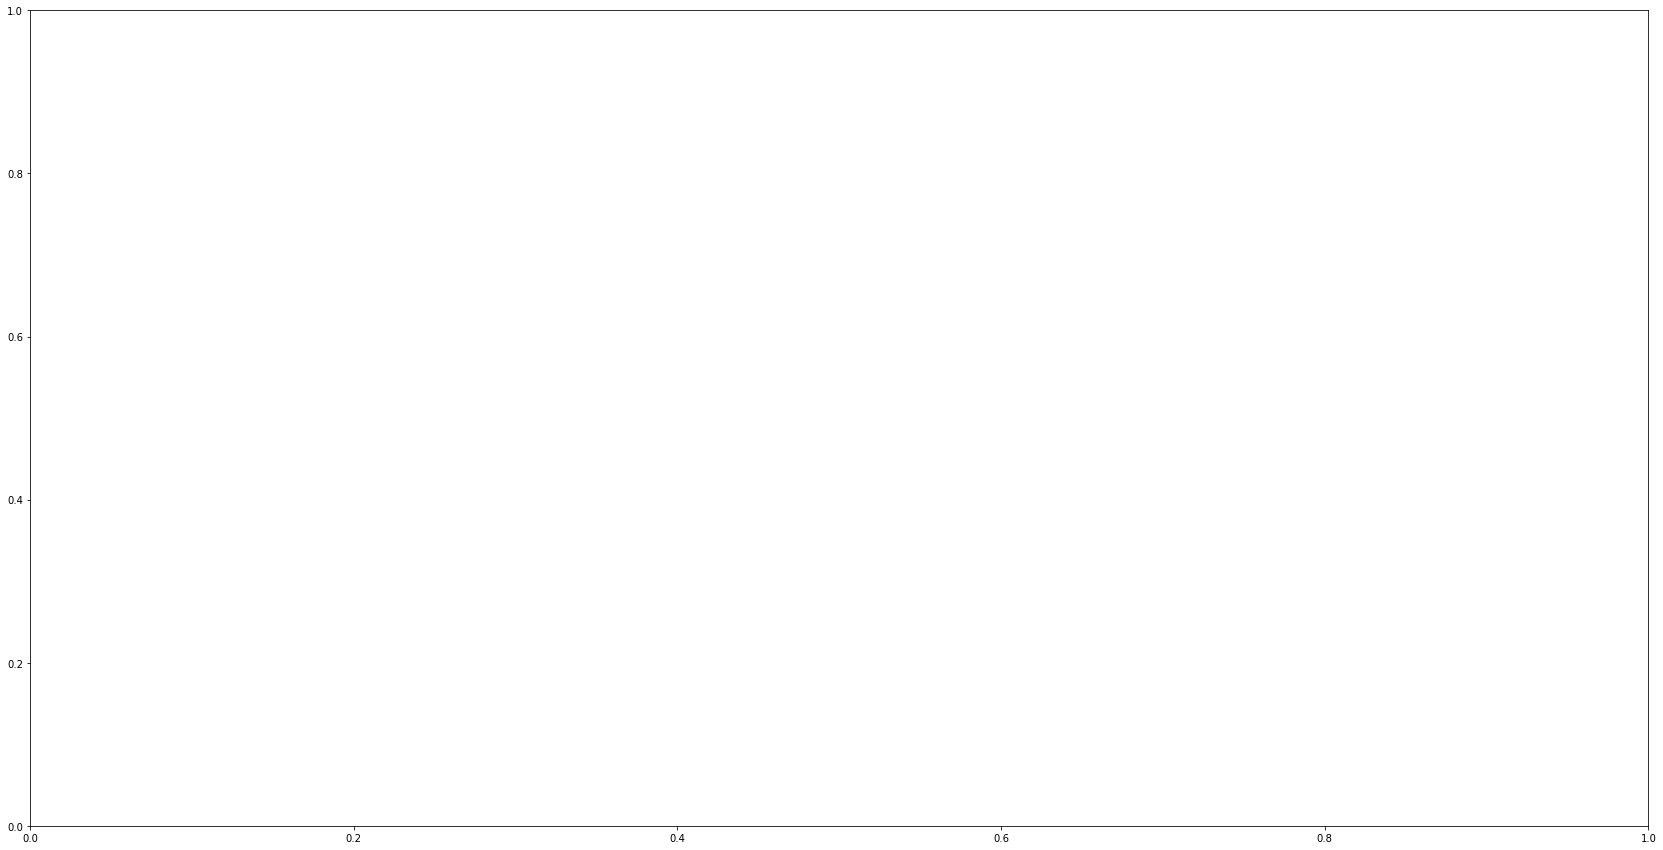

In [46]:
fig, axs = plt.subplots(figsize=(29, 15))
axs.hist(ntracks, bins=10, range=(0.0, 15), histtype='step', color='black', lw=2)

axs.set_xlabel('N tracks')
axs.set_title('Number of tracks from tracker')
# axs.legend()
plt.show()

In [ ]:
# fig, axs = plt.subplots(2,2,figsize=(11, 11))
# axs = axs.ravel()
# for i in range(1,)
# axs.scatter(xy[:,3,:][:, 0], xy[:,3,:][:, 1], s=2, color='black', label='All tracks')
# axs.set_xlim(0, 100)
# axs.set_ylim(0, 100)
# axs.legend(loc=3, markerscale=5)
# axs.set_xlabel('X [mm]')
# axs.set_ylabel('Y [mm]')
# plt.show()

In [ ]:
xy

In [73]:
ntracks[0:10]

array([3, 3, 3, 5, 4, 1, 4, 7, 6, 6], dtype=int32)

In [61]:
# track_files = {'/eos/home-i/iangelis/RD51/code/ebeam/analysis/July2023/Run320/anaRun320.root':'tracks'}

In [65]:
file_tracker = uproot.open('/eos/home-i/iangelis/RD51/code/ebeam/analysis/July2023/Run320/anaRun320.root')

In [67]:
srs_tracks = file_tracker["tracks"]["srstriggerctr"].array(library="np")
ntracks = file_tracker["tracks"]["ntracks"].array(library="np")
ndetsintrack = file_tracker["tracks"]["ndetsintrack"].array(library="np")
distnextcluster = file_tracker["tracks"]["distnextcluster"].array()
trackchi2 = file_tracker["tracks"]["trackchi2"].array(library="np")

# totchanextcluster = ftracks['tracks']['totchanextcluster'].array(library='np')
N = np.size(srs_tracks)
distnextcluster = np.asarray(distnextcluster)
distnextcluster = np.reshape(distnextcluster, (N, 6))
# print(np.shape(distnextcluster))

track_cut = np.logical_and(
    np.logical_and(ntracks == 1, ndetsintrack == 6),
    np.all(distnextcluster >= 600, axis=1),
)
flag_vec = np.empty(N)
flag_vec = np.where(track_cut == True, 1, -111)

srst_un, srst_id = np.unique(srs_tracks, return_index=True)

# all_srs = np.intersect1d(common_srs, srst_un)
# for i in range(N_POOLS):
#     masks[i] = np.isin(uniq_srs[i], all_srs)

# mask_tracks = np.isin(srst_un, all_srs)


In [ ]:
hits = file_tracker["tracks"]["hits"].array()
# hits = np.asarray(hits)[:, 3, :]
hits = np.asarray(hits)

IndexError: index 4 is out of bounds for axis 0 with size 4

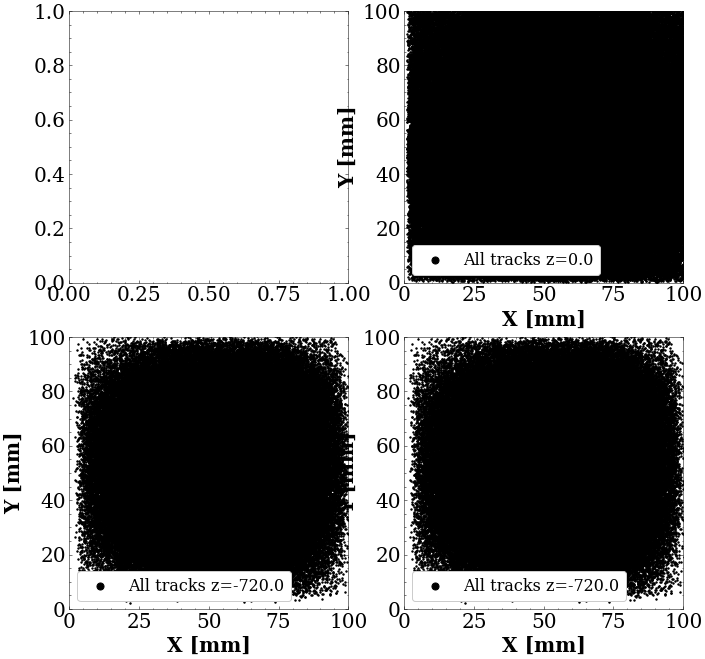

In [79]:
fig, axs = plt.subplots(2,2,figsize=(11, 11))
axs = axs.ravel()
for i in range(1,7):
    axs[i].scatter(hits[:,i,:][:, 0], hits[:,i,:][:, 1], s=2, color='black', label=f'All tracks z={hits[:,i][:, 2][0]}')
    axs[i].set_xlim(0, 100)
    axs[i].set_ylim(0, 100)
    axs[i].legend(loc=3, markerscale=5)
    axs[i].set_xlabel('X [mm]')
    axs[i].set_ylabel('Y [mm]')
plt.show()

In [77]:
hits[:,:,:][:,1]

array([[22.34464447, 61.87810298,  0.        ],
       [75.93840942, 41.37064829,  0.        ],
       [42.91159274, 42.63049537,  0.        ],
       ...,
       [65.03019686, 49.03963586,  0.        ],
       [41.61226528, 66.1886676 ,  0.        ],
       [50.07700087, 58.24934268,  0.        ]])

In [86]:
hits[:,,:]

array([[  54.87952871,   55.73089889, -720.        ],
       [  83.21953809,   40.86833661, -720.        ],
       [  71.49796699,   51.89298309, -720.        ],
       ...,
       [  74.61836684,   63.63587044, -720.        ],
       [  46.60705487,   83.33627516, -720.        ],
       [  30.50294575,   61.94635655, -720.        ]])

In [37]:
#define the cuts
mm_basic_cut = []

mcp_overflow = (mcp1_v>0)*(mcp1_v<=0.74)
mcp_basic_cut = mcp_overflow

for i in range(NPADS):       
    mm_overflow = (mm_vs[i] > 0.)*(mm_vs[i] < 0.36)*(mm_qalls[i] > 0)*(mm_qalls[i] < 250)
    qall_line = (mm_qalls[i] > 30. * mm_vs[i])
    cut = np.logical_and(mm_overflow * mcp_basic_cut, qall_line)
    mm_basic_cut.append(cut)


In [40]:
# cmap = plt.get_cmap('viridis')
cmap = plt.get_cmap('plasma')
pcolors = [cmap(i) for i in np.linspace(0, 1, 5)]

In [41]:
# qlow = 0.5
# qup = 80
# nppe = 500
# vl1in1, vu1in1, mdt1in1, sdt1in1, emdt1in1, esdt1in1 = fff(mm1_qall[xyc_inpad1], dt1[xyc_inpad1], qlow, qup, nppe, False, trange=[tranges[0][0], tranges[0][1]])

# xxs11 = (vl1in1+vu1in1)*0.5
# exs11 = (vl1in1-vu1in1)*0.5


In [42]:
# fig, axs = plt.subplots(2, 2, figsize=(22, 12))
# iistart, iistop = 0, -1
# axs = axs.ravel()

# axs[0].errorbar(xxs23[iistart:iistop], mdt2in3[iistart:iistop], xerr=exs23[iistart:iistop], yerr=emdt2in3[iistart:iistop], fmt='o', ms=7, color=pcolors[0], label=f'{pnames[1]}, hit {pnames[2]}')

# for i in range(4):
#     axs[i].grid()
#     axs[i].set_xlim(None, 50)
# #     axs[i].set_ylim(0, 1000)
# #     axs[i].set_ylim(show_ranges[i][0], show_ranges[i][1])
#     axs[i].set_xlabel('Total Charge [pC]')
#     axs[i].set_ylabel('SAT [ps]')
#     axs[i].legend(loc=1)

# # axs[0].set_xlim(0, 5)
# plt.show()


In [43]:
# fig, axs = plt.subplots(2, 2, figsize=(22, 12))
# iistart, iistop = 0, -1
# axs = axs.ravel()

# axs[0].errorbar(xxs23[iistart:iistop], sdt2in3[iistart:iistop], xerr=exs23[iistart:iistop], yerr=esdt2in3[iistart:iistop], fmt='o', ms=7, color=pcolors[0], label=f'{pnames[1]}, hit {pnames[2]}')



# for i in range(4):
#     axs[i].grid()
#     axs[i].set_xlim(None, 50)
# #     axs[i].set_ylim(0, 1000)
# #     axs[i].set_ylim(show_ranges[i][0], show_ranges[i][1])
#     axs[i].set_xlabel('Total Charge [pC]')
#     axs[i].set_ylabel('Resolution [ps]')
#     axs[i].legend(loc=1)

# # axs[0].set_xlim(0, 5)
# plt.show()


# Total Charge based Active Pad

In [44]:
# #same
# fig, axs = plt.subplots(2, 2, figsize=(22, 12))
# iistart, iistop = 0, -1
# axs = axs.ravel()
# a = np.linspace(5, 80, 300)

# axs[0].errorbar(xxsc22_qa[iistart:iistop], mdt2in2_qa[iistart:iistop], xerr=exsc22_qa[iistart:iistop], yerr=emdt2in2_qa[iistart:iistop], fmt='o', ms=7, color=colors[1], label=f'{pnames[1]}, hit {pnames[1]}')
# axs[0].plot(a, expo2_np(a, pars2in2_qa), color=colors[1])

# for i in range(4):
#     axs[i].grid()
#     axs[i].set_xlim(None, 80)
# #     axs[i].set_ylim(0, 1000)
# #     axs[i].set_ylim(show_ranges[i][0], show_ranges[i][1])
#     axs[i].set_xlabel('Total Charge [pC]')
#     axs[i].set_ylabel('SAT [ps]')
#     axs[i].legend(loc=1)

# # axs[0].set_xlim(0, 5)
# plt.show()


In [45]:
# qlow = 0.5
# qup = 80

# nppe = 500


# _,_, mdt1in1_qa_cor, sdt1in1_qa_cor, emdt1in1_qa_cor, esdt1in1_qa_cor = fff(mm1_qall[xyc_pad1_qa], dt1[xyc_pad1_qa]-expo2_np(mm1_qall[xyc_pad1_qa], pars1in1_qa)*1e-3, qlow, qup, nppe, False, trange=[-5000,5000])

In [46]:
# #same
# fig, axs = plt.subplots(2, 2, figsize=(22, 12))
# iistart, iistop = 0, -1
# axs = axs.ravel()

# axs[0].errorbar(xxsc22_qa[iistart:iistop], mdt2in2_qa_cor[iistart:iistop], xerr=exsc22_qa[iistart:iistop], yerr=emdt2in2_qa_cor[iistart:iistop], fmt='o', ms=7, color=colors[1], label=f'{pnames[1]}, hit {pnames[1]}')


# for i in range(4):
#     axs[i].grid()
#     axs[i].set_xlim(None, 80)
# #     axs[i].set_ylim(0, 1000)
# #     axs[i].set_ylim(show_ranges[i][0], show_ranges[i][1])
#     axs[i].set_xlabel('Total Charge [pC]')
#     axs[i].set_ylabel('SAT [ps]')
#     axs[i].legend(loc=1)

# # axs[0].set_xlim(0, 5)
# plt.show()


In [47]:
# spars1in1_qa = sat_fit(xxsc11_qa, sdt1in1_qa, exsc11_qa, esdt1in1_qa, iistart=0, iistop=None, xl=0.5, xu=80, pars=[-0.1,3.0,-1,0.5, 40])


In [48]:
# #same
# fig, axs = plt.subplots(2, 2, figsize=(22, 12))
# iistart, iistop = 0, -1
# axs = axs.ravel()
# a = np.linspace(5, 80, 300)

# axs[0].errorbar(xxsc22_qa[iistart:iistop], sdt2in2_qa[iistart:iistop], xerr=exsc22_qa[iistart:iistop], yerr=esdt2in2_qa[iistart:iistop], fmt='o', ms=7, color=colors[1], label=f'{pnames[1]}, hit {pnames[1]}')
# axs[0].plot(a, expo2_np(a, spars2in2_qa), color=colors[1])




# for i in range(4):
#     axs[i].grid()
#     axs[i].set_xlim(None, 80)
# #     axs[i].set_ylim(0, 1000)
# #     axs[i].set_ylim(show_ranges[i][0], show_ranges[i][1])
#     axs[i].set_xlabel('Total Charge [pC]')
#     axs[i].set_ylabel('Resolution [ps]')
#     axs[i].legend(loc=1)

# # axs[0].set_xlim(0, 5)
# plt.show()


In [49]:
# gpull11 = (dt1[xyc_pad1_qa]-expo2_np(mm1_qall[xyc_pad1_qa], pars1in1_qa)*1e-3)/(expo2_np(mm1_qall[xyc_pad1_qa], spars1in1_qa)*1e-3)

In [50]:
# cg = ROOT.TCanvas('cg', '', 1000, 800)
# cg.Divide(2,2)

# hgpull11 = ROOT.TH1D('hgp11', '', 100, -10,10)
# hgpull11.FillN(gpull11.size, gpull11, 0, 1)

# cg.cd(1)
# hgpull21.Draw()
# hgpull21.Fit('gaus')

# cg.Draw()

# Pad Centers

In [51]:
# tranges_xx = [
#  [-12000, -11000],
#  [-16500, -16000],
#  [-15700, -15000],
#  [-17000, -13000],
# ]

# hmean_sat = np.zeros((4, 10, 10))
# hmean_rms = np.zeros((4, 10, 10))
# htemps1 = []
# htemps2 = []
# htemps3 = []
# htemps4 = []

# htemps = [htemps1,htemps2,htemps3,htemps4]

# for ip,jp in enumerate(pad_order):
#     xbins = np.linspace(centers_s[0][jp]-5, centers_s[0][jp]+5, 11)
#     ybins = np.linspace(centers_s[1][jp]-5, centers_s[1][jp]+5, 11)
    
#     for j in range(1, 11):
#         for i in range(1,11):
    
#             xybin_cut = np.where(np.logical_and((x_s > xbins[i-1])*(x_s < xbins[i]), (y_s > ybins[j-1])*(y_s < ybins[j])))
# #             qq_cut = mm_qalls[ip][xybin_cut]>3
#         #             qq_in_bin = mm1_qall[box_cut][xybin_cut]
#             dt_in_bin = 1e3*mm_dts[jp][xybin_cut]
#             hxtemp = ROOT.TH1D(f'htemp{jp}_{i}_{j}', '', 100, tranges_xx[jp][0], tranges_xx[jp][1])

#             #             hxtemp.FillN(qq_in_bin.size, qq_in_bin, 0)
#             hxtemp.FillN(dt_in_bin.size, dt_in_bin, 0)
#             hxtemp.Fit('gaus', 'Q')
#             rsf = hxtemp.Fit('gaus', 'SQ')
#             if rsf.Get():
#                 hmean_sat[jp,i-1,j-1] = rsf.Parameter(1)
#                 hmean_rms[jp,i-1,j-1] = rsf.Parameter(2) 
            
#             htemps[jp].append(hxtemp)
# #     break

In [52]:
# fig, axs = plt.subplots(10, 10, figsize=(100, 100))
# for ip,jp in enumerate(pad_order):
#     xbins = np.linspace(centers_s[0][jp]-5, centers_s[0][jp]+5, 11)
#     ybins = np.linspace(centers_s[1][jp]-5, centers_s[1][jp]+5, 11)
#     for j in range(1, 11):
#         for i in range(1,11):
    
#             xybin_cut = np.where(np.logical_and((x_s > xbins[i-1])*(x_s < xbins[i]), (y_s > ybins[j-1])*(y_s < ybins[j])))
#             axs[j-1,i-1].scatter(x_s[xybin_cut], y_s[xybin_cut])
#             axs[j-1,i-1].set_xlim(-11,11)
#             axs[j-1,i-1].set_ylim(-11,11)
#     break
# plt.show()

In [53]:
# %jsroot off
# c = ROOT.TCanvas('cbins','', 8000, 8000)
# c.Divide(10, 10)
# for i in range(0, 100):
#     c.cd(i+1)
#     htemps[1][i].Draw()
# #     htemps[i].Fit('gaus', 'Q')

# c.Draw()

In [54]:
ROOT.gStyle.SetOptStat()

# Multiplicity

In [55]:
# dt1c = np.zeros((N, 2))

# dt1c[xyc_pad1_qa, 0] = 1e3*dt1[xyc_pad1_qa]-expo2_np(mm1_qall[xyc_pad1_qa], pars1in1_qa)
# dt1c[xyc_pad1_qa, 1] = expo2_np(mm1_qall[xyc_pad1_qa], spars1in1_qa)

In [56]:
class share_fun():
    def __init__(self, times, resols):
        self.times = times
        self.resols = resols
    def __call__(self, params):
        test = params[0]
        res = np.sum( np.square( test - self.times ) / np.square( self.resols ) )
        return res

